In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
df_acc = pd.read_csv('accepted_2007_to_2018Q4.csv', index_col=False, low_memory=False)

In [3]:
df_acc.dtypes

id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

In [4]:
df_acc.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,...,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,NaN,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,...,3.0,155.045981,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322
std,NaN,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,...,0.0,129.040594,0.0,9.671178,375.385500,7625.988281,198.629496,3693.122590,7.311822,8.159980
min,NaN,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,...,3.0,0.640000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000
25%,NaN,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.189000e+01,0.000000e+00,6.750000e+02,...,3.0,59.440000,3.0,5.000000,175.230000,5627.000000,44.440000,2208.000000,45.000000,6.000000
50%,NaN,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.784000e+01,0.000000e+00,6.900000e+02,...,3.0,119.140000,3.0,15.000000,352.770000,10028.390000,133.160000,4146.110000,45.000000,14.000000
75%,NaN,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.449000e+01,0.000000e+00,7.150000e+02,...,3.0,213.260000,3.0,22.000000,620.175000,16151.890000,284.190000,6850.172500,50.000000,18.000000
max,NaN,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,...,3.0,943.940000,3.0,37.000000,2680.890000,40306.410000,1407.860000,33601.000000,521.350000,181.000000


In [5]:
df_acc.isnull().sum()

id                             0
member_id                2260701
loan_amnt                     33
funded_amnt                   33
funded_amnt_inv               33
                          ...   
settlement_status        2226455
settlement_date          2226455
settlement_amount        2226455
settlement_percentage    2226455
settlement_term          2226455
Length: 151, dtype: int64

# I, Phân tích và tìm kiếm các biến phù hợp với bài toán

### 1, Loại bỏ cột trên 50% null

Các cột bị trên 50% giá trị null rất khó cho việc thay thế giá trị cũng như giá trị mang lại cũng không nhiều nên quyết định sẽ là loại bỏ

In [6]:
def drop_columns_with_nulls(df, threshold=0.5):
    row_count = len(df)
    null_threshold = threshold * row_count
    cols_to_drop = [col for col in df.columns if df[col].isnull().sum() > null_threshold]

    return df.drop(columns=cols_to_drop)

In [7]:
df_acc = drop_columns_with_nulls(df_acc)

In [8]:
df_acc.dtypes

id                             object
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
                               ...   
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
disbursement_method            object
debt_settlement_flag           object
Length: 107, dtype: object

### 2, Phân tích PCA với các côt số

In [9]:
numeric_df = df_acc.select_dtypes(include=['number'])
cleaned_df = numeric_df.dropna(axis=0)

pcs = PCA()
pcs.fit(cleaned_df)

PCA()

In [10]:
summ = {'Standard deviation': np.sqrt(pcs.explained_variance_), 'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)}
pcsSummary_df = pd.DataFrame(summ)
pcsSummary_df = pcsSummary_df.transpose()
pcsSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary_df.columns) + 1)]
pcsSummary_df.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
Standard deviation,252640.0475,79317.8395,69642.9786,44379.8617,26827.9582,19203.7333,18667.7675,14689.7862,9753.0105,8664.2895,...,0.1255,0.0999,0.0981,0.0979,0.0729,0.0306,0.0146,0.0083,0.0003,0.0
Proportion of variance,0.8087,0.0797,0.0615,0.0250,0.0091,0.0047,0.0044,0.0027,0.0012,0.0010,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
Cumulative proportion,0.8087,0.8884,0.9499,0.9749,0.9840,0.9887,0.9931,0.9958,0.9970,0.9980,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0


In [11]:
kaiser_criteria = pcsSummary_df.loc['Standard deviation'] > 1
selected_pcs = pcsSummary_df.loc[:, kaiser_criteria]
selected_pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59
Standard deviation,252640.047532,79317.839543,69642.978604,44379.861669,26827.958203,19203.733280,18667.767465,14689.786197,9753.010548,8664.289529,...,2.856727e+00,2.607033e+00,2.173094e+00,2.075427e+00,1.751020e+00,1.579204e+00,1.508048e+00,1.353608e+00,1.138645e+00,1.121239e+00
Proportion of variance,0.808734,0.079716,0.061455,0.024956,0.009120,0.004673,0.004416,0.002734,0.001205,0.000951,...,1.034044e-10,8.611814e-11,5.983546e-11,5.457783e-11,3.884935e-11,3.159933e-11,2.881589e-11,2.321598e-11,1.642776e-11,1.592933e-11
Cumulative proportion,0.808734,0.888450,0.949905,0.974861,0.983980,0.988653,0.993069,0.995803,0.997008,0.997959,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(), columns=pcsSummary_df.columns, #Note the use of the
index=cleaned_df.columns)
pcsComponents_df.loc[:, kaiser_criteria]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59
loan_amnt,1.241591e-02,2.049103e-02,1.258490e-03,4.964563e-02,1.485356e-02,1.140101e-01,4.199975e-01,0.161732,-6.231898e-02,-4.213312e-02,...,1.741847e-04,-8.196264e-05,-1.243018e-04,-4.131299e-05,3.063790e-06,-0.000194,0.000206,-4.569748e-05,1.650708e-05,-6.478201e-05
funded_amnt,1.241595e-02,2.049109e-02,1.258639e-03,4.964542e-02,1.485405e-02,1.140113e-01,4.199973e-01,0.161733,-6.231698e-02,-4.213513e-02,...,-6.551757e-04,2.223761e-03,-6.816379e-04,8.861358e-04,2.009551e-04,-0.000150,0.000140,-1.159000e-03,7.129562e-04,-2.587736e-04
funded_amnt_inv,1.241519e-02,2.048602e-02,1.255735e-03,4.963730e-02,1.484617e-02,1.140017e-01,4.198968e-01,0.161819,-6.233089e-02,-4.213300e-02,...,4.794738e-04,-2.178111e-03,7.976199e-04,-8.503488e-04,-2.097847e-04,0.000323,-0.000324,1.214519e-03,-7.232584e-04,3.166692e-04
int_rate,-2.298535e-06,-1.038751e-06,7.162663e-06,-2.042549e-05,2.764451e-05,-2.444212e-05,5.472690e-05,0.000018,-2.310385e-05,1.697946e-05,...,1.030113e-01,3.948956e-02,-8.010059e-04,-2.913885e-02,-1.464676e-02,0.001869,-0.033186,-2.571036e-02,-9.017061e-03,2.048793e-03
installment,3.208274e-04,6.095852e-04,5.311143e-05,1.292424e-03,5.982187e-04,2.883947e-03,1.205954e-02,0.003042,-1.439479e-03,-6.283678e-04,...,-1.931527e-04,4.707351e-04,1.235708e-05,-2.095354e-05,-3.119529e-05,0.000526,-0.000611,-1.087360e-04,-1.323609e-04,4.555801e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tax_liens,-2.758984e-09,1.567656e-07,-6.048556e-08,-2.417059e-07,-6.536822e-08,-3.278570e-07,5.616423e-07,-0.000001,-1.427885e-07,-2.566930e-07,...,4.778785e-04,-3.052603e-03,2.927876e-03,-5.374705e-04,2.082553e-03,-0.000223,0.001361,-1.609810e-03,-3.087608e-04,-4.434599e-03
tot_hi_cred_lim,7.285293e-01,-1.239466e-01,-1.309459e-01,2.265387e-01,-4.785354e-01,-3.586837e-01,6.416055e-02,-0.009421,-1.296057e-01,8.137738e-02,...,-3.668058e-07,-7.026405e-07,6.479395e-07,1.853844e-07,1.859134e-07,-0.000001,0.000001,1.743258e-07,-3.378338e-07,1.650941e-07
total_bal_ex_mort,1.204914e-01,1.891455e-01,5.519683e-01,1.508567e-01,3.248770e-01,-2.194661e-01,-3.923426e-03,-0.009407,-2.700328e-01,2.189353e-01,...,9.992188e-06,1.577023e-05,4.417527e-06,7.458817e-06,-1.328209e-05,0.000004,-0.000002,-2.852716e-06,-5.965967e-08,-8.734281e-07
total_bc_limit,3.629390e-02,4.344923e-02,-1.734568e-02,4.215611e-01,-5.701656e-02,4.736356e-01,-8.852469e-02,-0.005052,1.591991e-01,6.124408e-01,...,-1.720386e-04,1.094724e-04,-9.882457e-05,1.413553e-05,4.356938e-06,-0.000024,0.000021,1.385365e-07,5.085200e-06,3.025142e-06


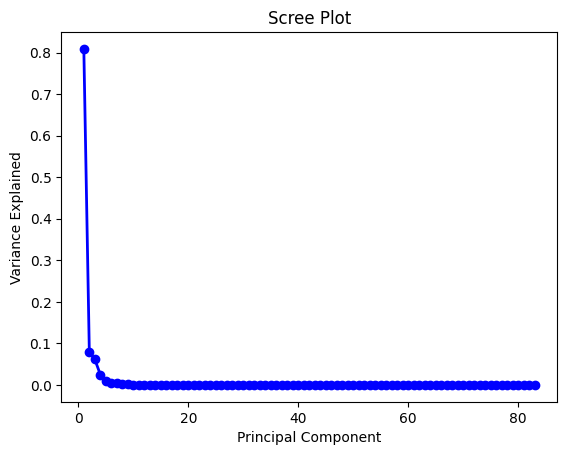

In [13]:
PC_values = np.arange(pcs.n_components_) + 1
plt.plot(PC_values, pcs.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [14]:
filtered_features = pcsComponents_df.loc[:, kaiser_criteria].apply(lambda x: cleaned_df.columns[x > 0.6], axis=0)
feature = []
for idx, values in filtered_features.items(): 
    feature.extend(values.dropna().tolist())
feature = list(set(feature))
print(len(feature))
feature

40


['mths_since_recent_bc',
 'mo_sin_rcnt_tl',
 'int_rate',
 'mort_acc',
 'loan_amnt',
 'total_rev_hi_lim',
 'revol_bal',
 'il_util',
 'total_bc_limit',
 'avg_cur_bal',
 'max_bal_bc',
 'last_fico_range_low',
 'recoveries',
 'mo_sin_rcnt_rev_tl_op',
 'delinq_amnt',
 'tot_cur_bal',
 'last_pymnt_amnt',
 'total_acc',
 'annual_inc',
 'total_il_high_credit_limit',
 'bc_util',
 'collection_recovery_fee',
 'pct_tl_nvr_dlq',
 'mo_sin_old_rev_tl_op',
 'mths_since_recent_inq',
 'mo_sin_old_il_acct',
 'installment',
 'tot_coll_amt',
 'tot_hi_cred_lim',
 'inq_last_12m',
 'total_rec_late_fee',
 'funded_amnt_inv',
 'total_cu_tl',
 'last_fico_range_high',
 'mths_since_rcnt_il',
 'dti',
 'total_rec_int',
 'num_bc_tl',
 'num_accts_ever_120_pd',
 'inq_fi']

ta có 40 biến thành phần chính dạng numberic sau khi phân tích pca nhưng số biến cần cho mô hình không nên quá nhiều nên sẽ lọc bớt các biết như VD: total...., pub_rec_bankruptcies, recoveries,  dự vào hệ số tương quan, kết hợp với vài chỉ số quan trọng như pub_rec_bankruptcies, annual_inc..

In [15]:
cleaned_df[feature]

,mths_since_recent_bc,mo_sin_rcnt_tl,int_rate,mort_acc,loan_amnt,total_rev_hi_lim,revol_bal,il_util,total_bc_limit,avg_cur_bal,...,total_rec_late_fee,funded_amnt_inv,total_cu_tl,last_fico_range_high,mths_since_rcnt_il,dti,total_rec_int,num_bc_tl,num_accts_ever_120_pd,inq_fi
0,4.0,3.0,13.99,1.0,3600.0,9300.0,2765.0,36.0,2400.0,20701.0,...,0.00,3600.0,1.0,564.0,21.0,5.91,821.72,5.0,2.0,3.0
1,2.0,2.0,11.99,4.0,24700.0,111800.0,21470.0,73.0,79300.0,9733.0,...,0.00,24700.0,0.0,699.0,19.0,16.06,979.66,17.0,0.0,0.0
2,101.0,14.0,10.78,5.0,20000.0,14000.0,7869.0,73.0,6200.0,31617.0,...,0.00,20000.0,5.0,704.0,19.0,10.78,2705.92,4.0,0.0,2.0
4,4.0,4.0,22.45,6.0,10400.0,34000.0,21929.0,84.0,20300.0,27644.0,...,0.00,10400.0,1.0,704.0,14.0,25.37,1340.50,9.0,0.0,2.0
6,12.0,10.0,9.17,4.0,20000.0,94200.0,87329.0,63.0,31500.0,30030.0,...,0.00,20000.0,0.0,654.0,18.0,14.67,1393.80,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,0.0,0.0,10.49,0.0,24000.0,100300.0,22448.0,31.0,93700.0,2088.0,...,0.00,24000.0,0.0,739.0,44.0,10.98,4928.86,14.0,0.0,0.0
2260695,15.0,15.0,10.49,4.0,24000.0,55600.0,21665.0,77.0,27900.0,6369.0,...,0.00,24000.0,12.0,734.0,16.0,34.94,4959.95,18.0,12.0,1.0
2260696,41.0,15.0,10.49,3.0,40000.0,13300.0,8633.0,46.0,12300.0,5680.0,...,0.00,40000.0,0.0,724.0,15.0,12.75,8156.52,15.0,6.0,3.0
2260697,9.0,9.0,14.49,2.0,24000.0,25900.0,17641.0,78.0,20700.0,6243.0,...,0.00,24000.0,0.0,594.0,20.0,18.30,3233.49,15.0,1.0,0.0


In [16]:
feature.append("loan_status")
feature

['mths_since_recent_bc',
 'mo_sin_rcnt_tl',
 'int_rate',
 'mort_acc',
 'loan_amnt',
 'total_rev_hi_lim',
 'revol_bal',
 'il_util',
 'total_bc_limit',
 'avg_cur_bal',
 'max_bal_bc',
 'last_fico_range_low',
 'recoveries',
 'mo_sin_rcnt_rev_tl_op',
 'delinq_amnt',
 'tot_cur_bal',
 'last_pymnt_amnt',
 'total_acc',
 'annual_inc',
 'total_il_high_credit_limit',
 'bc_util',
 'collection_recovery_fee',
 'pct_tl_nvr_dlq',
 'mo_sin_old_rev_tl_op',
 'mths_since_recent_inq',
 'mo_sin_old_il_acct',
 'installment',
 'tot_coll_amt',
 'tot_hi_cred_lim',
 'inq_last_12m',
 'total_rec_late_fee',
 'funded_amnt_inv',
 'total_cu_tl',
 'last_fico_range_high',
 'mths_since_rcnt_il',
 'dti',
 'total_rec_int',
 'num_bc_tl',
 'num_accts_ever_120_pd',
 'inq_fi',
 'loan_status']

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

newClean = df_acc[feature]
newClean['loan_status'] = label_encoder.fit_transform(newClean['loan_status'])
correlations = newClean.corr()['loan_status'].abs().sort_values(ascending=False)
top_features = correlations.index[:15]
top_features

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6124\3745084462.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newClean['loan_status'] = label_encoder.fit_transform(newClean['loan_status'])


Index(['loan_status', 'last_pymnt_amnt', 'recoveries', 'last_fico_range_high',
       'collection_recovery_fee', 'last_fico_range_low', 'int_rate',
       'mort_acc', 'funded_amnt_inv', 'loan_amnt', 'num_bc_tl', 'dti',
       'total_acc', 'inq_last_12m', 'installment'],
      dtype='object')

các cột như  last_fico_range_high vs last_fico_range_low sẽ thay thế bằng fico_range_high vs fico_range_low vì ta khổng thế lấy 1 khoảng thời gian gần đây để đánh giá tổng thể được

Vậy các cột số sẽ lấy là 'annual_inc', 'pub_rec', 'fico_range_high',
       'pub_rec_bankruptcies', 'fico_range_low', 'int_rate',
       'mort_acc', 'funded_amnt_inv', 'loan_amnt', 'num_bc_tl', 'dti',
       'open_acc', 'inq_last_12m', 'installment', 'revol_bal', 'revol_util'

In [18]:
number_feature = ['annual_inc', 'pub_rec', 'fico_range_high',
       'pub_rec_bankruptcies', 'fico_range_low', 'int_rate',
       'mort_acc', 'funded_amnt_inv', 'loan_amnt', 'num_bc_tl', 'dti',
       'open_acc', 'inq_last_12m', 'installment', 'revol_bal', 'revol_util']
len(number_feature)

16

### 3, Chọn lọc các cột còn lại

In [19]:
import warnings
warnings.filterwarnings("ignore")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106],
 [Text(0, 0, 'id'),
  Text(1, 0, 'loan_amnt'),
  Text(2, 0, 'funded_amnt'),
  Text(3, 0, 'funded_amnt_inv'),
  Text(4, 0, 'term'),
  Text(5, 0, 'int_rate'),
  Text(6, 0, 'installment'),
  Text(7, 0, 'grade'),
  Text(8, 0, 'sub_grade'),
  Text(9, 0, 'home_ownership'),
  Text(10, 0, 'issue_d'),
  Text(11, 0, 'verification_status'),
  Text(12, 0, 'loan_status')

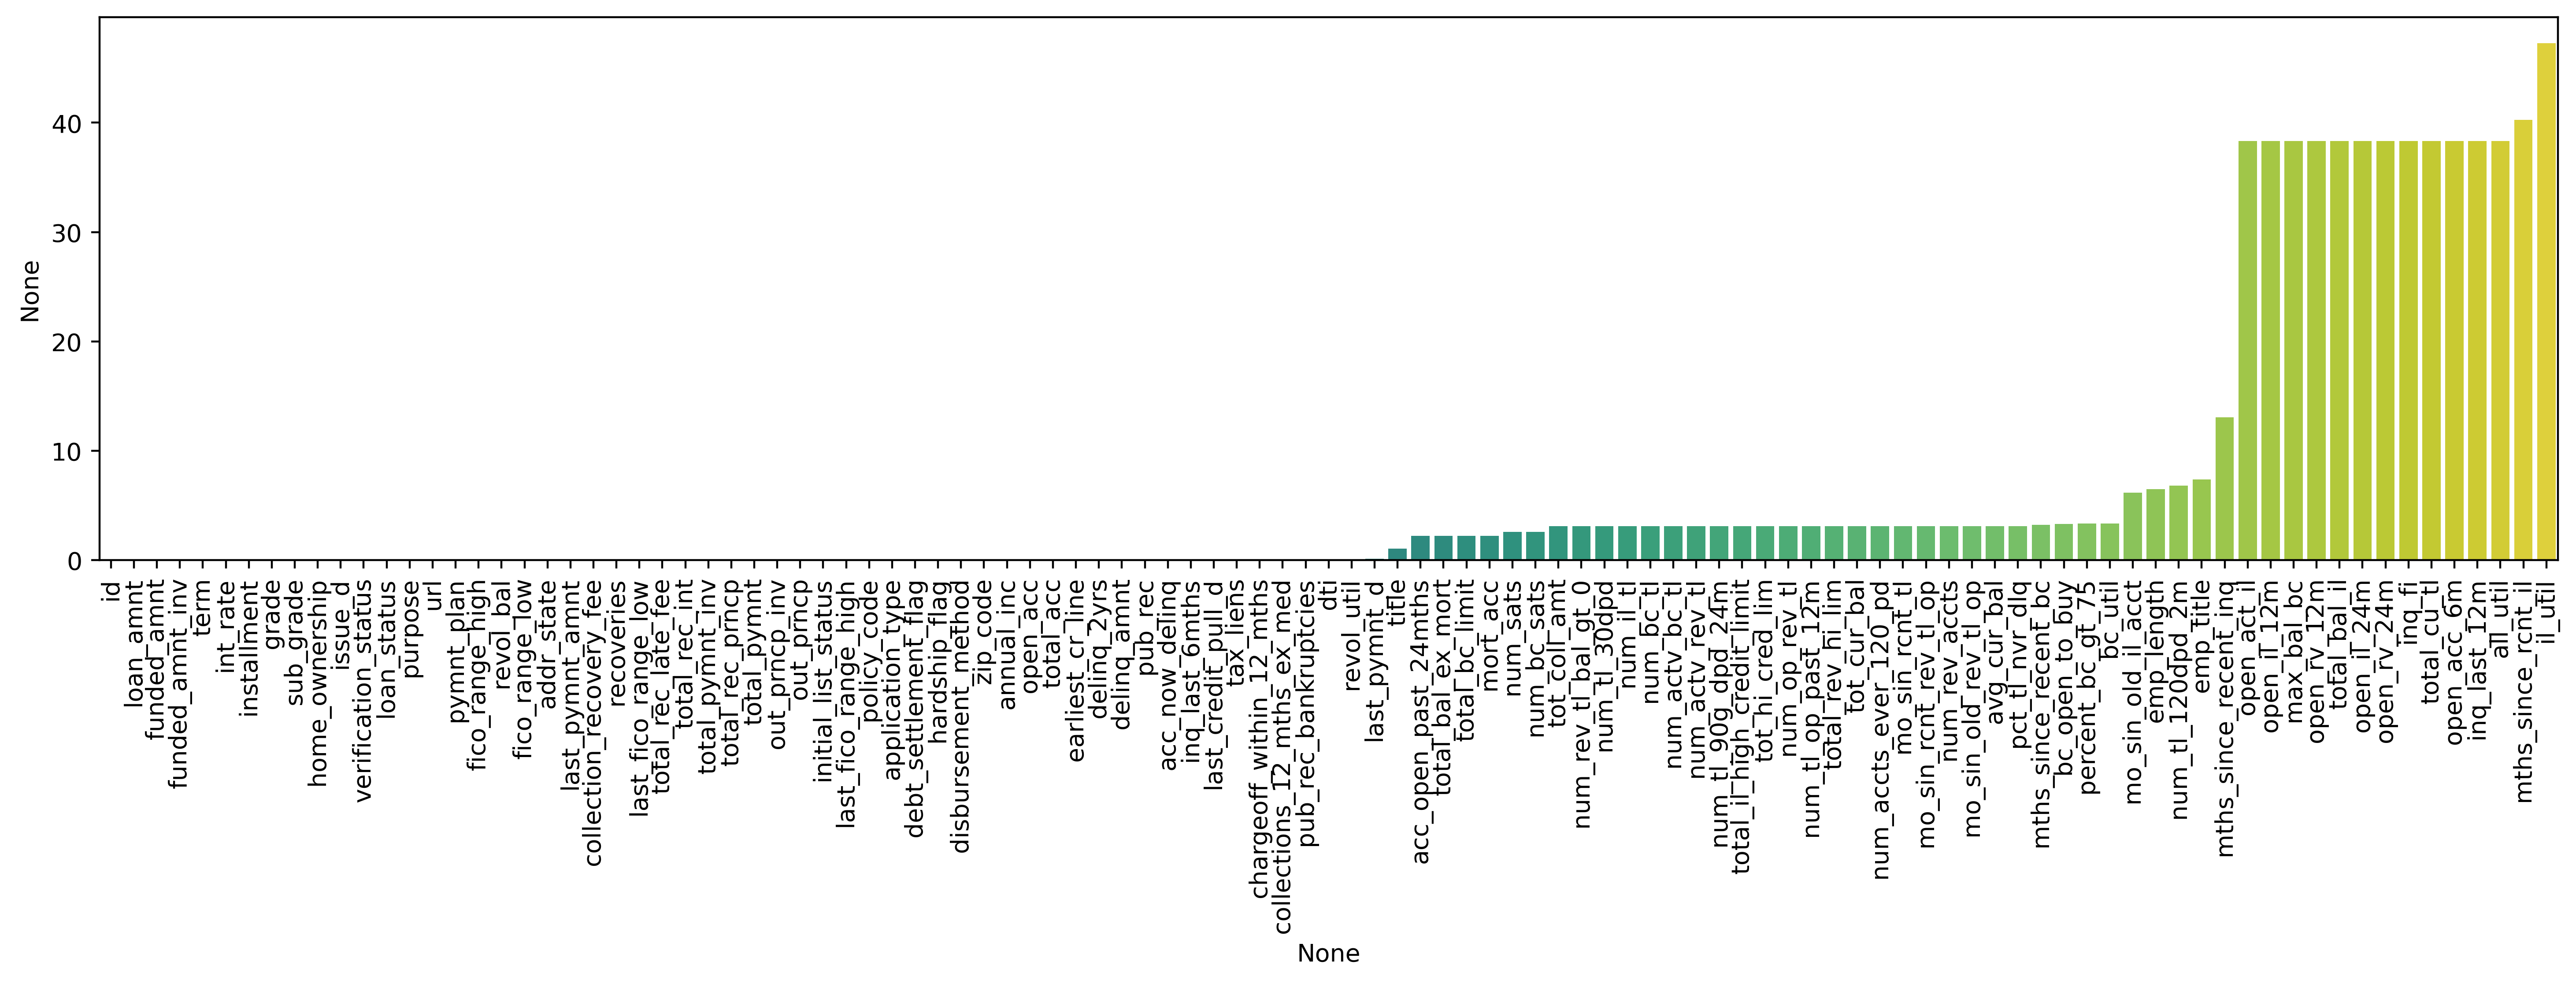

In [20]:
plt.figure(figsize=(18,4),dpi=400)
sns.barplot(y=((df_acc.isnull().sum()/len(df_acc))*100).sort_values(), x=((df_acc.isnull().sum()/len(df_acc))*100).sort_values().index, palette='viridis')
plt.xticks(rotation=90)

có khá nhiều trường không phù hợp cho người lần đầu vay nên sẽ loại bỏ và cũng như chỉ giữa lại các cột liên quan cũng như quan trọng cho bài toán

In [21]:
string_feature = [ 'earliest_cr_line', 'emp_length', 'emp_title', 'grade', 'home_ownership', 'application_type',
                    'initial_list_status', 'loan_status',  'purpose',  'sub_grade', 'term', 'title', 'verification_status'
                ]


In [22]:
final_feature = []
final_feature.extend(number_feature)
final_feature.extend(string_feature)
final_feature

['annual_inc',
 'pub_rec',
 'fico_range_high',
 'pub_rec_bankruptcies',
 'fico_range_low',
 'int_rate',
 'mort_acc',
 'funded_amnt_inv',
 'loan_amnt',
 'num_bc_tl',
 'dti',
 'open_acc',
 'inq_last_12m',
 'installment',
 'revol_bal',
 'revol_util',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'grade',
 'home_ownership',
 'application_type',
 'initial_list_status',
 'loan_status',
 'purpose',
 'sub_grade',
 'term',
 'title',
 'verification_status']

In [23]:
df = df_acc[final_feature]
df.dtypes

annual_inc              float64
pub_rec                 float64
fico_range_high         float64
pub_rec_bankruptcies    float64
fico_range_low          float64
int_rate                float64
mort_acc                float64
funded_amnt_inv         float64
loan_amnt               float64
num_bc_tl               float64
dti                     float64
open_acc                float64
inq_last_12m            float64
installment             float64
revol_bal               float64
revol_util              float64
earliest_cr_line         object
emp_length               object
emp_title                object
grade                    object
home_ownership           object
application_type         object
initial_list_status      object
loan_status              object
purpose                  object
sub_grade                object
term                     object
title                    object
verification_status      object
dtype: object

### II, Tiền sử lý dữ liệu, phân tích dữ liệu, trích chọn đặc trưng

In [24]:
df.dtypes.value_counts()

float64    16
object     13
Name: count, dtype: int64

In [25]:
df['loan_status']

0           Fully Paid
1           Fully Paid
2           Fully Paid
3              Current
4           Fully Paid
              ...     
2260696        Current
2260697    Charged Off
2260698        Current
2260699            NaN
2260700            NaN
Name: loan_status, Length: 2260701, dtype: object

In [26]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [27]:
df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [28]:
df_temp = df[number_feature + ['loan_status']]
df_temp['loan_status'] = pd.get_dummies(df_temp['loan_status'], drop_first=False).iloc[:, 0]

In [29]:
len(df)

1345310

<Axes: xlabel='loan_status', ylabel='count'>

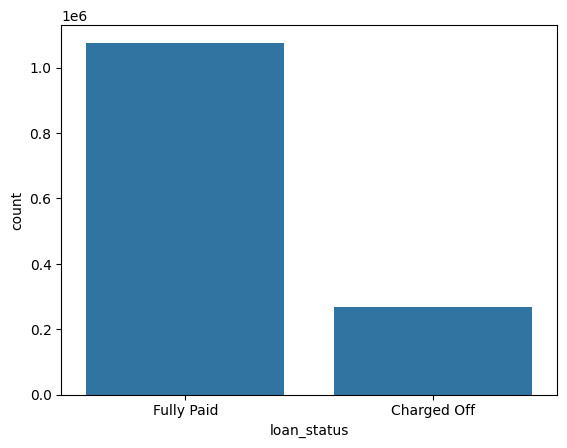

In [30]:
sns.countplot(x=df['loan_status'], data=df)

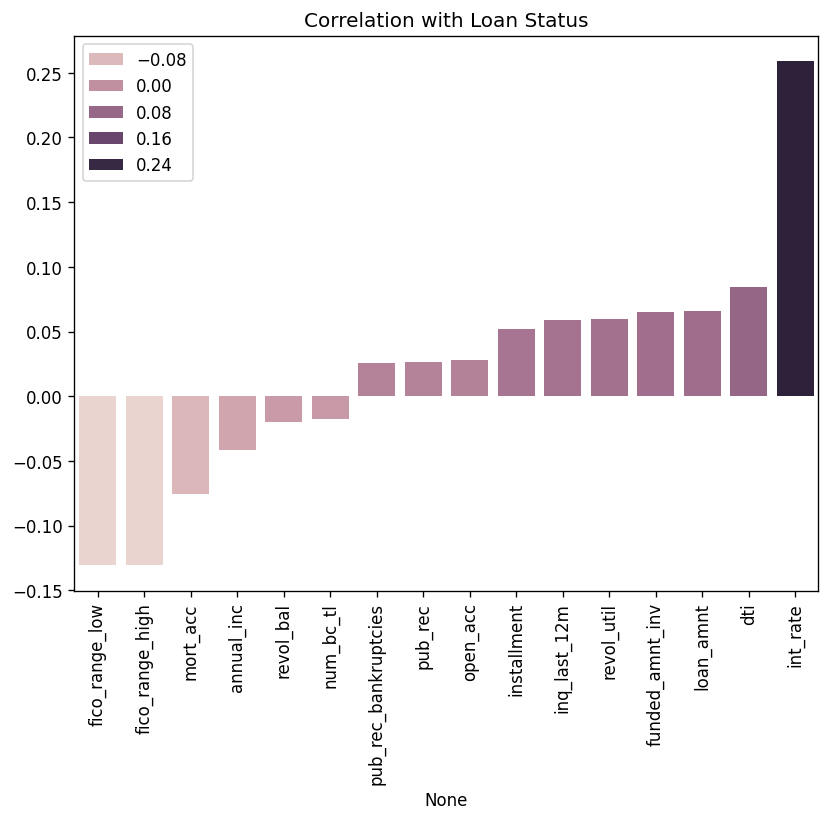

In [31]:
correlation = df_temp.corr()['loan_status'].sort_values().drop('loan_status')
plt.figure(figsize=(8, 6), dpi=120)
sns.barplot(x=correlation.index, y=correlation.values, hue=correlation.values)
plt.title('Correlation with Loan Status')
plt.xticks(rotation=90)
plt.show()

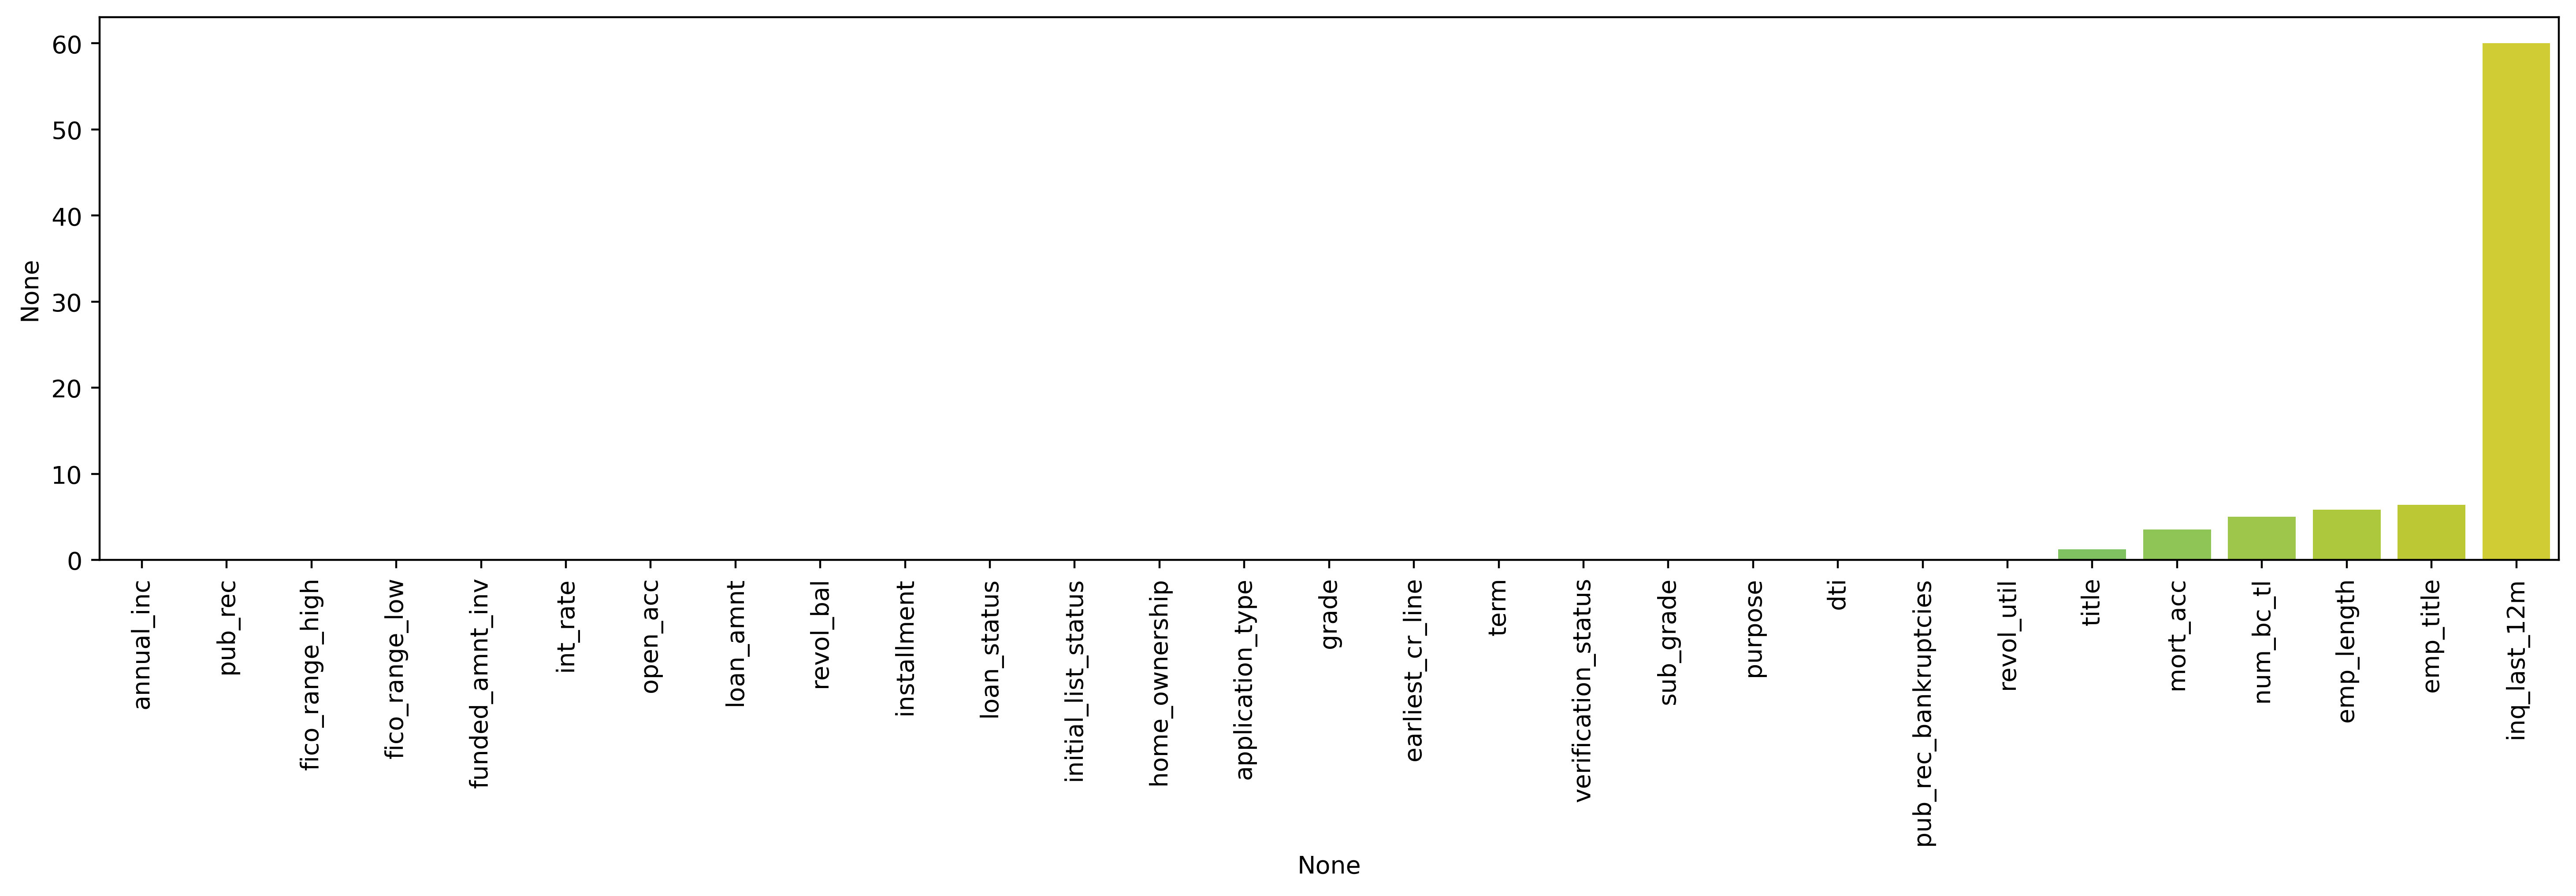

In [32]:
plt.figure(figsize=(18,4),dpi=400)
sns.barplot(y=((df.isnull().sum()/len(df))*100).sort_values(), x=((df.isnull().sum()/len(df))*100).sort_values().index, palette='viridis')
plt.xticks(rotation=90);

In [33]:
df_missing = ((df.isnull().sum()/len(df))*100)[((df.isnull().sum()/len(df))*100) > 0]
df_missing

pub_rec_bankruptcies     0.051810
mort_acc                 3.514506
num_bc_tl                5.019438
dti                      0.027800
inq_last_12m            60.039173
revol_util               0.063703
emp_length               5.835904
emp_title                6.376597
title                    1.238376
dtype: float64

In [34]:
def if_null_values(feat_name):
    if feat_name in df_missing:
        print((f"% of missing values = {df_missing[feat_name].round(2)}"))
    else:
        print(("No missing values"))

### 1, annual_inc

Thu nhập hàng năm tự báo cáo do người vay cung cấp trong quá trình đăng ký.

In [35]:
if_null_values("annual_inc")

No missing values


In [36]:
df['annual_inc'].describe()

count    1.345310e+06
mean     7.624764e+04
std      6.992510e+04
min      0.000000e+00
25%      4.578000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

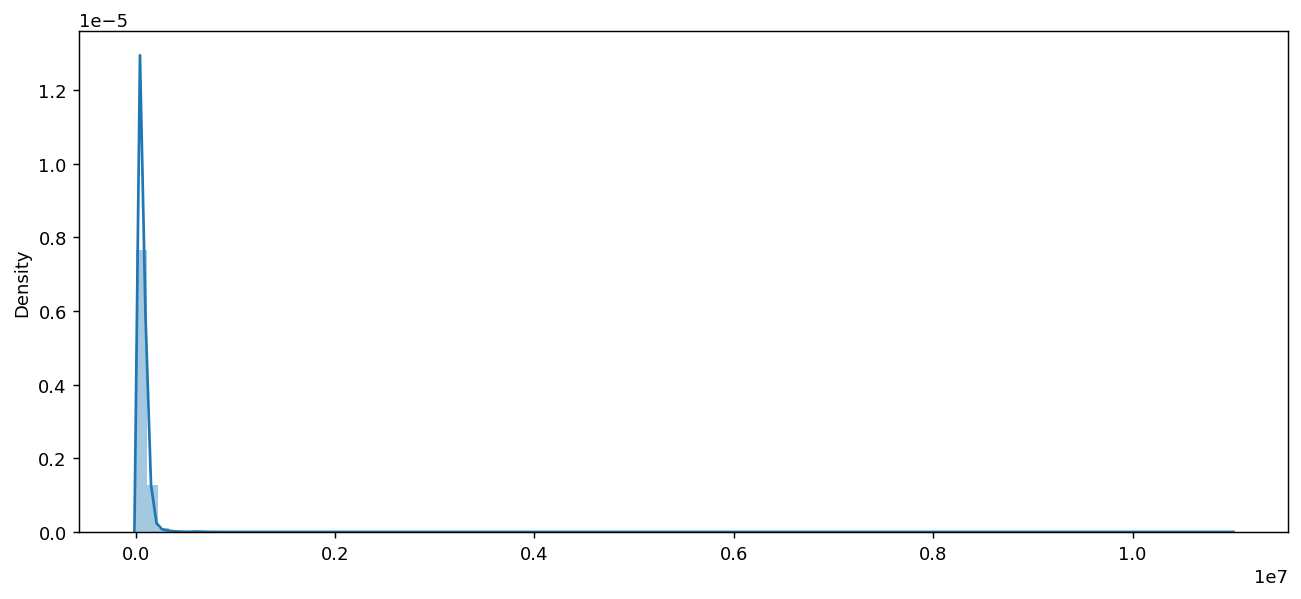

In [37]:
plt.figure(figsize=(12,5), dpi=130)
sns.distplot(x=df['annual_inc'], bins=100);

thu nhâp hàng năm quá lệch về bên phải có thể sẽ loải bỏ ngoại lai

In [38]:
q1 = df['annual_inc'].quantile(0.25)  
q3 = df['annual_inc'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 2 * iqr
upper_bound = q3 + 2 * iqr

<Axes: ylabel='Density'>

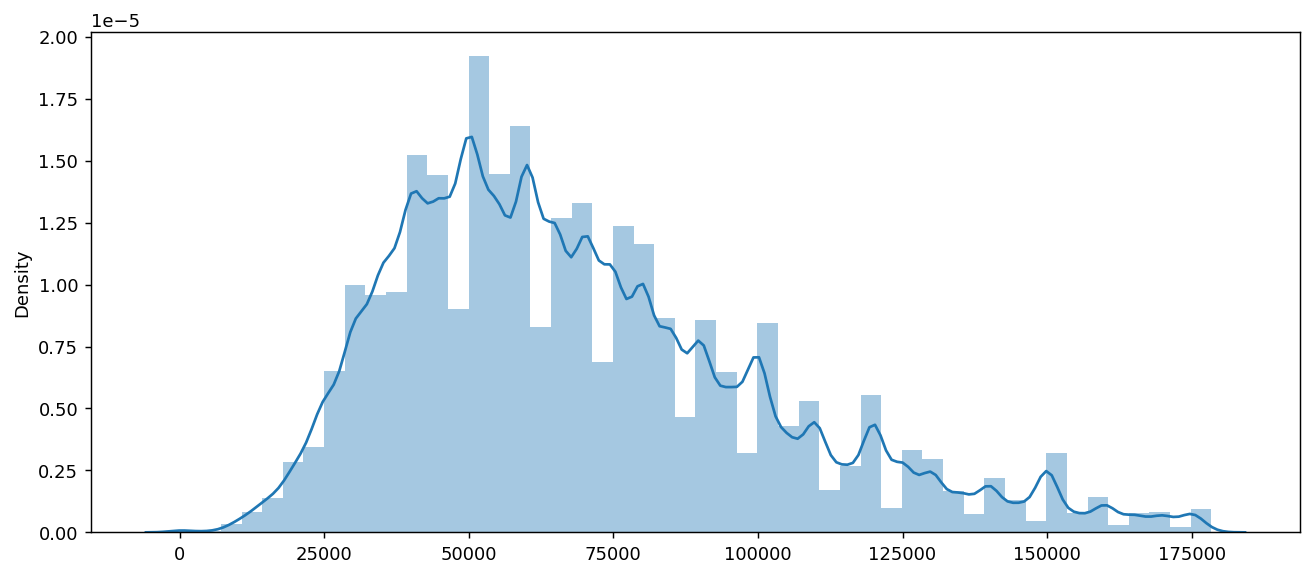

In [39]:
df = df[(df['annual_inc'] >= lower_bound) & (df['annual_inc'] <= upper_bound)]

plt.figure(figsize=(12,5), dpi=130)
sns.distplot(x=df['annual_inc'], kde=True)

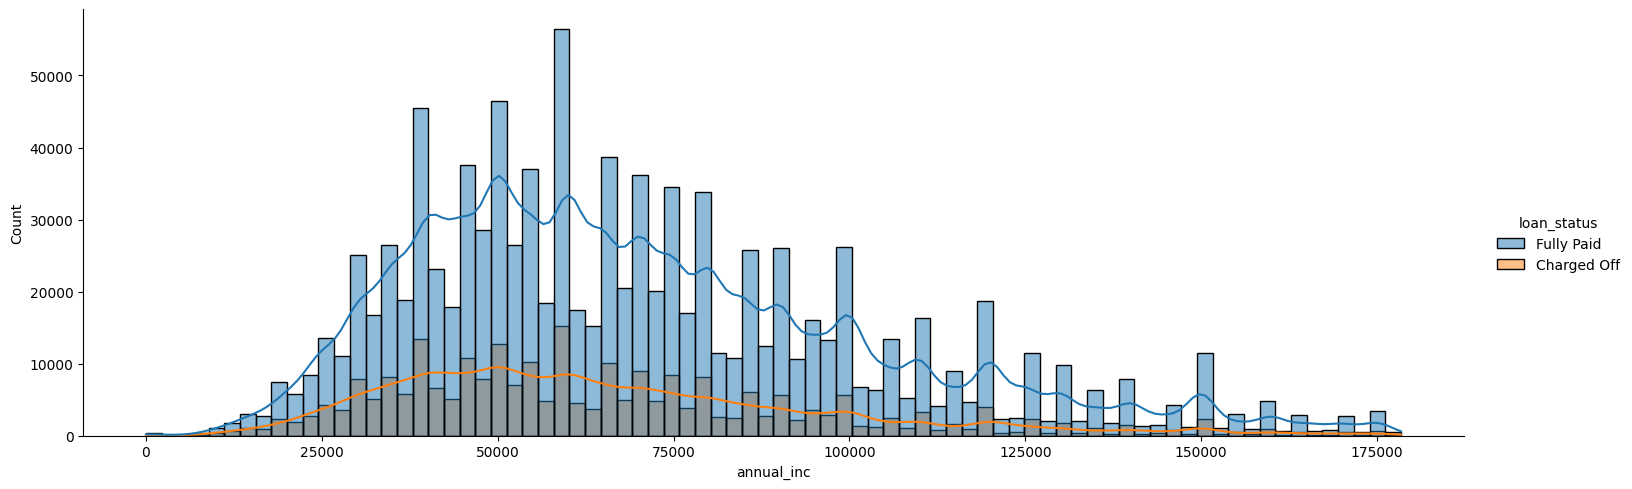

In [40]:
sns.displot(data=df, x='annual_inc', hue='loan_status', bins=80, height=5, aspect=3, kde=True);

In [41]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,262098.0,65550.386030,31034.906494,0.0,43000.0,60000.0,81086.25,178323.45
Fully Paid,1038146.0,70524.353944,32733.823079,0.0,46000.0,65000.0,90000.00,178400.00


Thu nhập trung bình hàng năm của những khách hàng đã thanh toán đầy đủ khoản vay và những khách hàng không thanh toán khác nhau khoảng 5.000 USD.

### 2, pub_rec

In [42]:
if_null_values('pub_rec')

No missing values


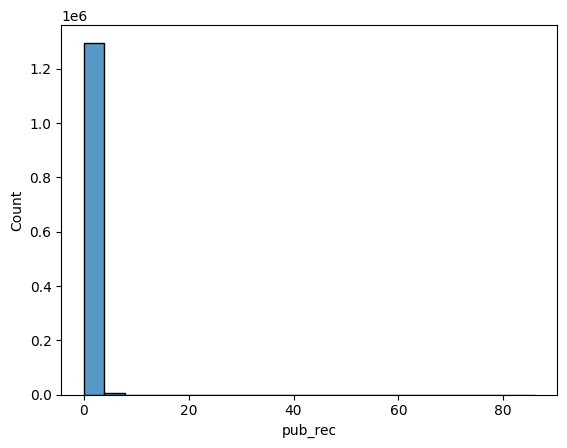

In [43]:
sns.histplot(data=df, x='pub_rec');

có nhiều ngoại lai vs giá trị pub_rec > 2

In [44]:
# số % ngoại lai với pub_rec > 2
len(df[df['pub_rec'] > 2])*100/len(df)

0.9065990690978001

In [45]:
df = df[df['pub_rec'] <= 2]

In [46]:
df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,259365.0,0.206300,0.454651,0.0,0.0,0.0,0.0,2.0
Fully Paid,1029091.0,0.174756,0.422935,0.0,0.0,0.0,0.0,2.0


Sự khác biệt rất nhỏ có thể thấy trong giá trị trung bình của 'pub_rec' giữa hai nhóm 'loan_status'

### 3, fico_range_high và fico_range_low

last_fico_range_low: Đây là điểm tín dụng thấp nhất trong phạm vi điểm tín dụng gần nhất của người vay. FICO score là một điểm số tín dụng mà các tổ chức tín dụng sử dụng để đánh giá khả năng trả nợ của một cá nhân. Phạm vi này cho biết người vay có điểm tín dụng thấp nhất trong khoảng nào.
<br>
last_fico_range_high: Đây là điểm tín dụng cao nhất trong phạm vi điểm tín dụng gần nhất của người vay. Nó cho biết mức điểm tín dụng cao nhất mà người vay có thể đạt được trong phạm vi đó.

In [47]:
if_null_values('fico_range_high')

No missing values


In [48]:
if_null_values('fico_range_low')

No missing values


In [49]:
df['fico_range_high'].describe()

count    1.288456e+06
mean     7.000272e+02
std      3.172807e+01
min      6.290000e+02
25%      6.740000e+02
50%      6.940000e+02
75%      7.140000e+02
max      8.500000e+02
Name: fico_range_high, dtype: float64

In [50]:
df['fico_range_low'].describe()

count    1.288456e+06
mean     6.960271e+02
std      3.172746e+01
min      6.250000e+02
25%      6.700000e+02
50%      6.900000e+02
75%      7.100000e+02
max      8.450000e+02
Name: fico_range_low, dtype: float64

Thay thế 2 côt fico high vs low bằng giá trị trung bình đề giám số chiều dữ liệu

In [51]:
df['fico'] = (df['fico_range_high'] + df['fico_range_low']) / 2
df['fico']

0          677.0
1          717.0
2          697.0
4          697.0
5          692.0
           ...  
2260685    722.0
2260686    687.0
2260688    737.0
2260691    737.0
2260697    662.0
Name: fico, Length: 1288456, dtype: float64

In [52]:
df = df.drop(['fico_range_high', 'fico_range_low'], axis=1)

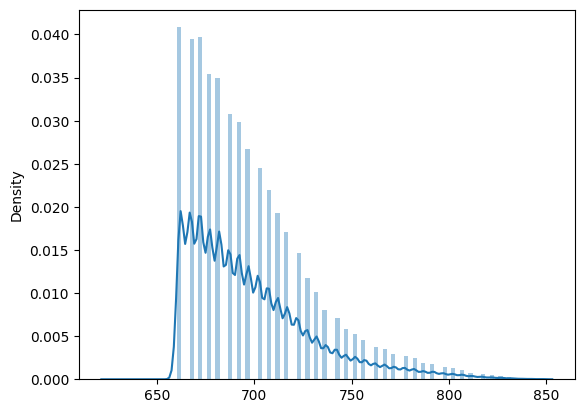

In [53]:
sns.distplot(x=df['fico'], bins=100);

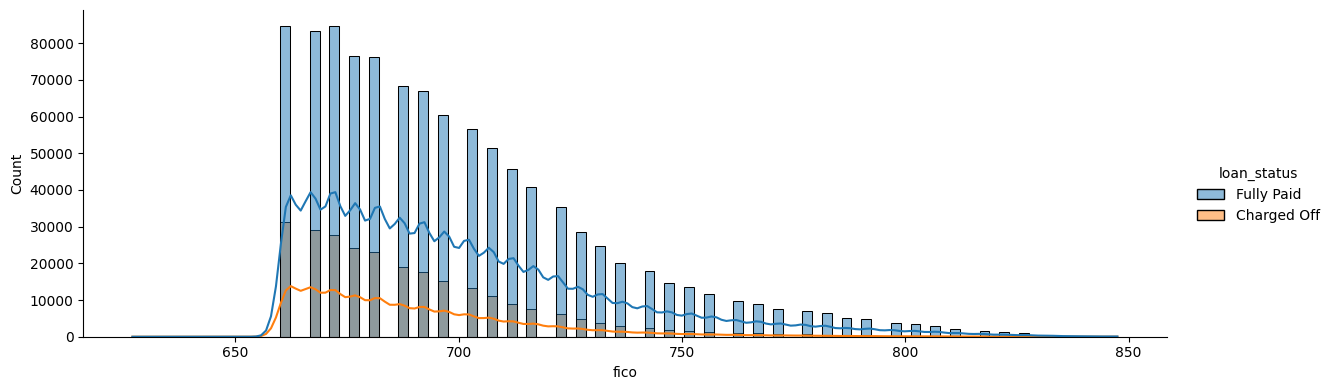

In [54]:
sns.displot(data=df, x='fico', hue='loan_status', bins=100, height=4, aspect=3, kde=True);

<Axes: xlabel='fico', ylabel='loan_status'>

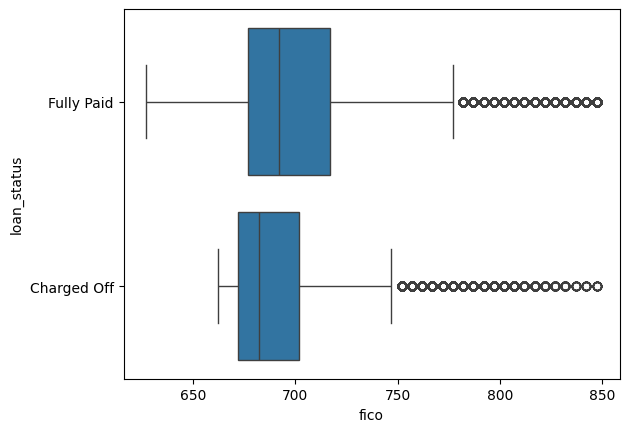

In [55]:
sns.boxplot(data=df, y='loan_status', x='fico')

In [56]:
df.groupby('loan_status')['fico'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,259365.0,689.838267,25.905317,662.0,672.0,682.0,702.0,847.5
Fully Paid,1029091.0,700.090976,32.711854,627.0,677.0,692.0,717.0,847.5


không sự khác biệt nhiều giữa điểm FICO của những khách hàng đã thanh toán đầy đủ khoản vay và những khách hàng không thanh toán đầy đủ.

### 4, earliest_cr_line

Tháng mở tài khoản tín dụng được báo cáo sớm nhất.

In [57]:
if_null_values('earliest_cr_line')

No missing values


In [58]:
df['earliest_cr_line'].sample(10)

383029     Aug-2003
2194503    Mar-2004
952129     Sep-2007
287657     Aug-2007
1030910    Oct-1990
419232     Aug-2008
1241906    Oct-2000
2056392    Jul-1994
917538     Dec-1979
100166     Apr-2009
Name: earliest_cr_line, dtype: object

Thông tin không quá quan trọng có thể loại bỏ cột tháng chỉ giữa lại năm.

In [59]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))

In [60]:
df['earliest_cr_line'].sample(10)

1601457    2006
384283     2005
689572     1994
1784064    2002
1780755    2003
1835445    1998
1343506    2002
1222891    2000
1263943    2004
1704831    2008
Name: earliest_cr_line, dtype: int64

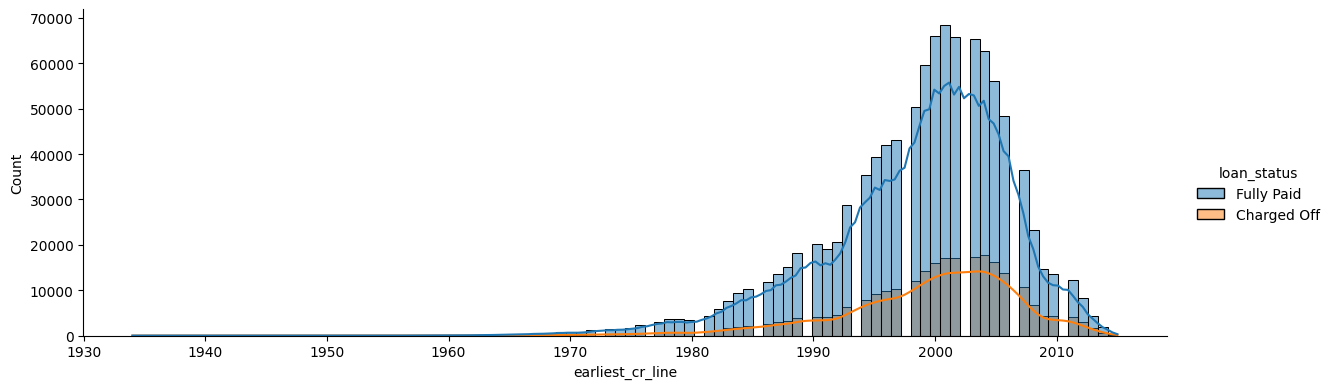

In [61]:
sns.displot(data=df, x='earliest_cr_line', hue='loan_status', bins=100, height=4, aspect=3, kde=True);

In [62]:
df.groupby('loan_status')['earliest_cr_line'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,259365.0,1999.452470,7.547636,1944.0,1996.0,2001.0,2005.0,2015.0
Fully Paid,1029091.0,1998.677304,7.557800,1934.0,1995.0,2000.0,2004.0,2015.0


Thời điểm trung bình tài khoản tín dụng sớm nhất của những khách hàng đã thanh toán đầy đủ khoản vay sớm hơn khoảng 1 năm so với những khách hàng không thanh toán khoản vay

Không quá nhiều giá trị có thể loại bỏ khi cho vào mô hình học máy


In [63]:
df = df.drop('earliest_cr_line', axis=1)

### 5, emp_length

Độ dài thời gian làm việc tính bằng năm. Các giá trị có thể nằm trong khoảng từ 0 đến 10, trong đó 0 có nghĩa là dưới một năm và 10 có nghĩa là mười năm hoặc hơn

In [64]:
if_null_values('emp_length')

% of missing values = 5.84


In [65]:
df['emp_length'].sample(10)

70013        7 years
923035       2 years
53778      10+ years
1350072    10+ years
2098317    10+ years
1969014      5 years
1815772    10+ years
2207720     < 1 year
218431      < 1 year
1218794    10+ years
Name: emp_length, dtype: object

In [66]:
df['emp_length'].value_counts()

emp_length
10+ years    421260
2 years      116627
< 1 year     104011
3 years      102975
1 year        85217
5 years       80381
4 years       76940
6 years       60021
8 years       57997
7 years       57053
9 years       48851
Name: count, dtype: int64

In [67]:
emp_length_order = [ '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

<Axes: xlabel='emp_length', ylabel='count'>

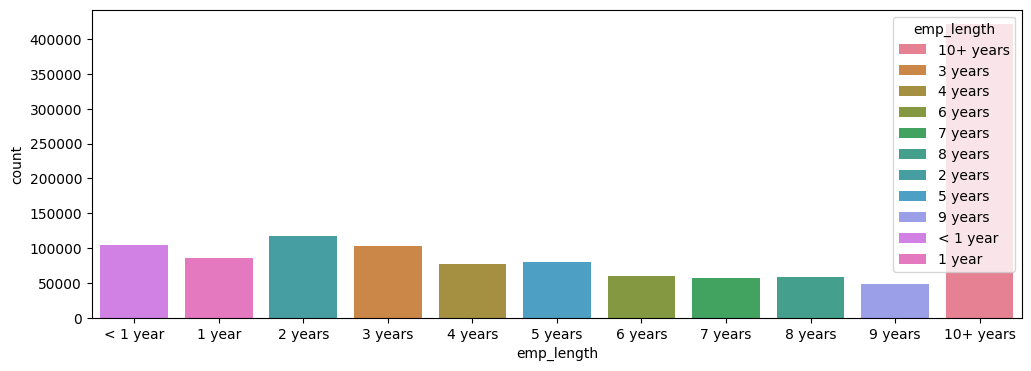

In [68]:
plt.figure(figsize=(12,4))
sns.countplot(x='emp_length',data=df,order=emp_length_order, hue='emp_length')

<Axes: xlabel='emp_length', ylabel='count'>

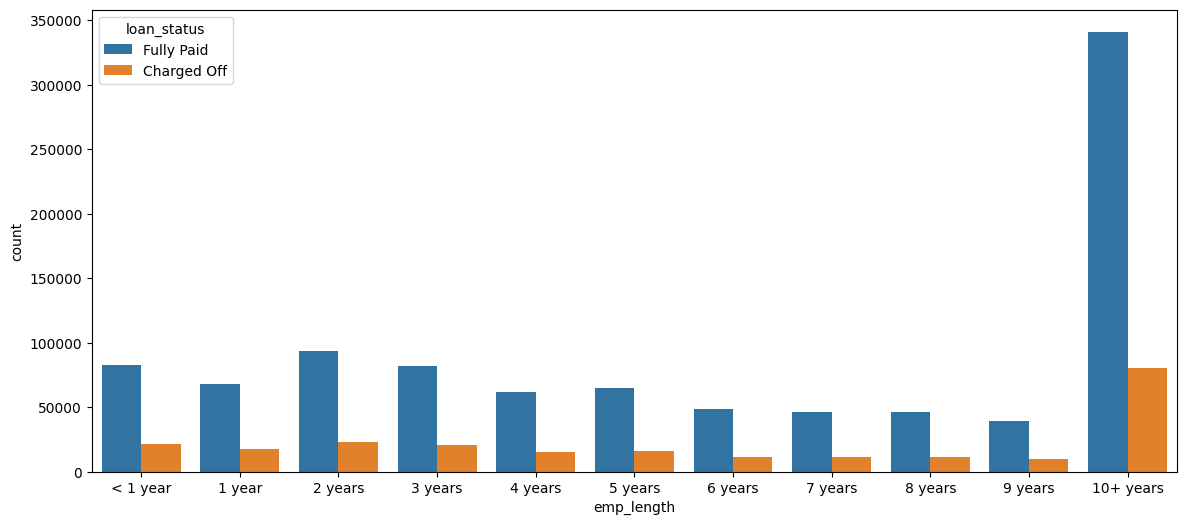

In [69]:
plt.figure(figsize=(14,6))
sns.countplot(x='emp_length',data=df,order=emp_length_order,hue='loan_status')

Dữ liệu chưa cho thấy liệu có mối quan hệ nào giữa emp_length và "Charged Off" hay không. 

In [70]:
# tính % charged off theo từng nhóm năm làm việc
emp_charged_off = df[df['loan_status']=="Charged Off"].groupby("emp_length").count()['loan_status']
emp_fully_paid = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']
percentage_charged_off = (emp_charged_off * 100)/(emp_charged_off + emp_fully_paid)
percentage_charged_off

emp_length
1 year       20.700095
10+ years    18.999668
2 years      19.918201
3 years      20.114591
4 years      19.870029
5 years      19.691221
6 years      19.476517
7 years      19.672936
8 years      20.082073
9 years      20.044625
< 1 year     20.654546
Name: loan_status, dtype: float64

<Axes: xlabel='emp_length', ylabel='loan_status'>

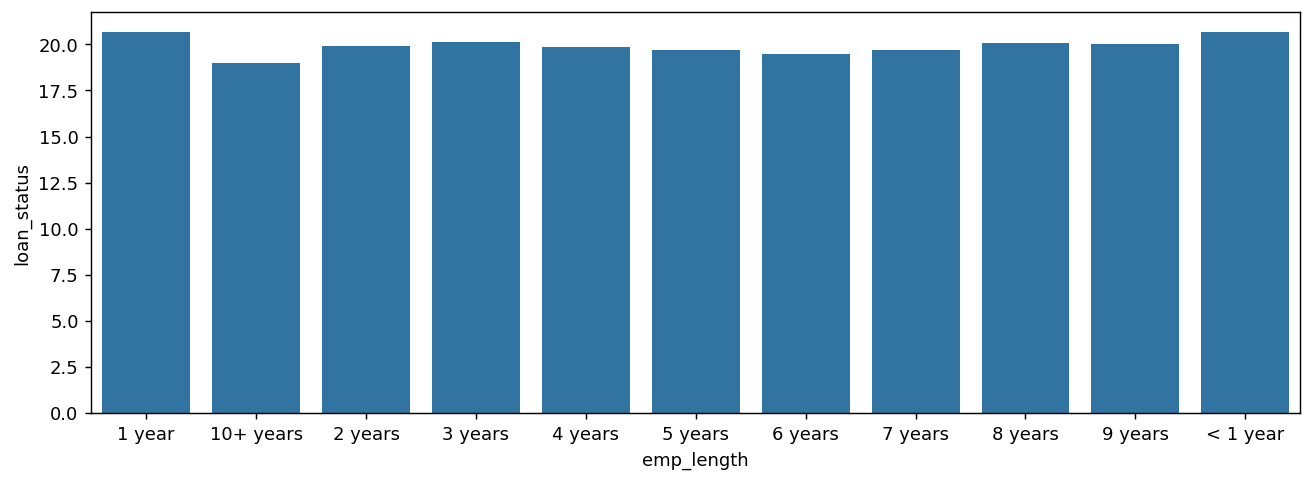

In [71]:
plt.figure(figsize=(12,4), dpi=130)
sns.barplot(percentage_charged_off)

Không có bất kì sự khác biệt nào. Nên tốt nhất là loại bỏ đê giảm chiều dữ liệu

In [72]:
df = df.drop('emp_length', axis=1)

In [73]:
df.columns

Index(['annual_inc', 'pub_rec', 'pub_rec_bankruptcies', 'int_rate', 'mort_acc',
       'funded_amnt_inv', 'loan_amnt', 'num_bc_tl', 'dti', 'open_acc',
       'inq_last_12m', 'installment', 'revol_bal', 'revol_util', 'emp_title',
       'grade', 'home_ownership', 'application_type', 'initial_list_status',
       'loan_status', 'purpose', 'sub_grade', 'term', 'title',
       'verification_status', 'fico'],
      dtype='object')

### 6, emp_title

Chức danh công việc được người vay cung cấp khi nộp đơn xin vay

In [74]:
if_null_values('emp_title')

% of missing values = 6.38


In [75]:
df['emp_title'].describe()

count     1204801
unique     366409
top       Teacher
freq        21104
Name: emp_title, dtype: object

366409 giá trị khác biệt. Quá khó cho việc sửa lý và nếu sử lý cũng tạo ra quá nhiều chiều dữ liệu nên tốt nhất là loại bỏ

In [76]:
df = df.drop('emp_title', axis=1)

### 7, grade và sub_grade

LC (Lending Club) gán xếp hạng khoản vay (grade) và xếp hạng phụ (sub_grade).

In [77]:
unique_grades = df['grade'].unique()
unique_sub_grades = df['sub_grade'].unique()

sorted(unique_grades)

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [78]:
sorted(unique_sub_grades)

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5']

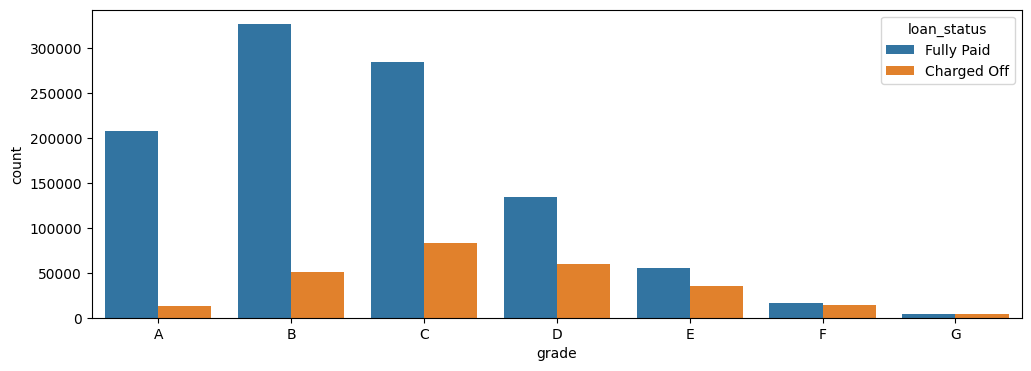

In [79]:
plt.figure(figsize=(12,4))
sns.countplot(x='grade',data=df,hue='loan_status', order=sorted(df['grade'].unique()),);

<Axes: xlabel='sub_grade', ylabel='count'>

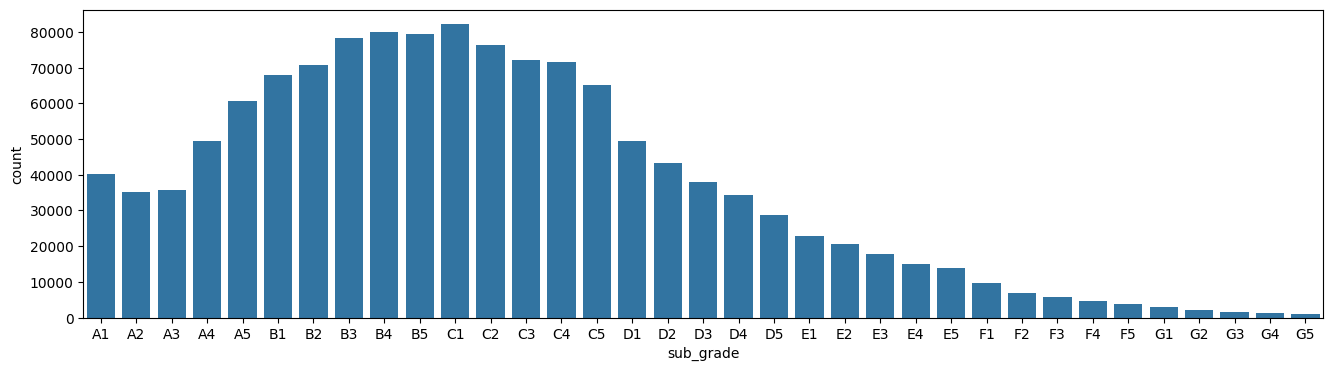

In [80]:
plt.figure(figsize=(16,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order)


Kiểm tra số lượng khách hàng trong mỗi sub_grade được phân tách bằng loan_status

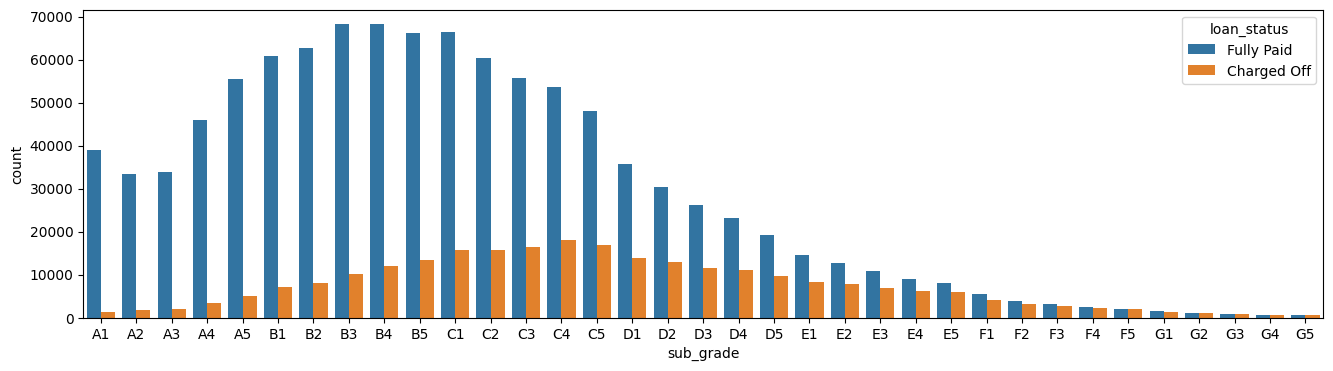

In [81]:
plt.figure(figsize=(16,4))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order = subgrade_order ,hue='loan_status');

Dựa vào 2 biều đồ grade và subgrade ta thấy chúng tương tự nhau nhưng sub_grade mang nhiều thông tin hơn cũng như chi tiết hơn. Nên chúng ta sẽ loại bảo cột grade

In [82]:
df = df.drop('grade', axis=1)

In [83]:
sub_grade = pd.get_dummies(df['sub_grade'], drop_first=False)

In [84]:
df = pd.concat([df.drop('sub_grade', axis=1), sub_grade], axis=1)

In [85]:
df.dtypes

annual_inc              float64
pub_rec                 float64
pub_rec_bankruptcies    float64
int_rate                float64
mort_acc                float64
funded_amnt_inv         float64
loan_amnt               float64
num_bc_tl               float64
dti                     float64
open_acc                float64
inq_last_12m            float64
installment             float64
revol_bal               float64
revol_util              float64
home_ownership           object
application_type         object
initial_list_status      object
loan_status              object
purpose                  object
term                     object
title                    object
verification_status      object
fico                    float64
A1                         bool
A2                         bool
A3                         bool
A4                         bool
A5                         bool
B1                         bool
B2                         bool
B3                         bool
B4      

### 8, home_ownership

Chế độ sở hữu nhà do người vay cung cấp trong quá trình đăng ký hoặc lấy từ báo cáo tín dụng. Các giá trị có thể là:
<br>
RENT: Thuê nhà
<br>
OWN: Sở hữu nhà
<br>
MORTGAGE: Có khoản vay thế chấp
<br>
OTHER: Các hình thức sở hữu khác
<br>

In [86]:
if_null_values('home_ownership')

No missing values


In [87]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    629568
RENT        519748
OWN         138681
ANY            272
OTHER          139
NONE            48
Name: count, dtype: int64

thay thế ANY và NONE thành OTHER 

In [88]:
df['home_ownership'] = df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

<Axes: xlabel='home_ownership', ylabel='count'>

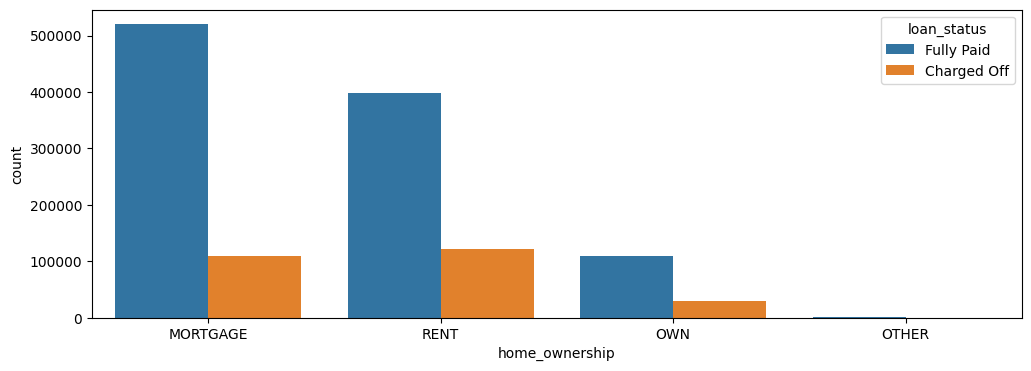

In [89]:
plt.figure(figsize=(12,4))
sns.countplot(x='home_ownership',data=df,hue='loan_status')

In [90]:
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    629568
RENT        519748
OWN         138681
OTHER          459
Name: count, dtype: int64

tính tỷ lệ phần trăm bị "charged off" theo từng loại home_ownership

<Axes: xlabel='home_ownership', ylabel='loan_status'>

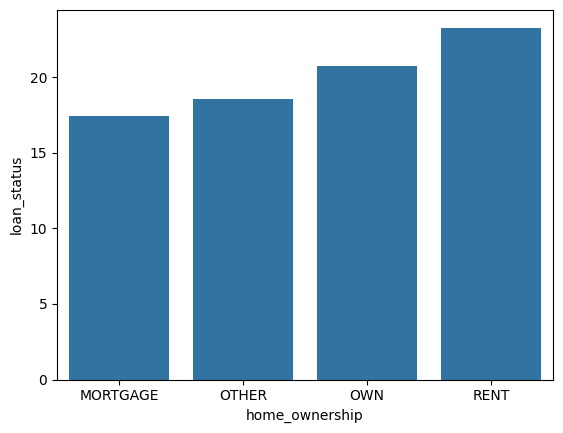

In [91]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("home_ownership").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("home_ownership").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
sns.barplot(percentage_charged_off)

Có khác biệt rõ ràng giữa các loại quyền sở hữu nhà khác nhau

In [92]:
home_ownership = pd.get_dummies(df['home_ownership'], drop_first=False)

In [93]:
df = pd.concat([df.drop('home_ownership', axis=1), home_ownership], axis=1)

In [94]:
df.shape


(1288456, 61)

### 9, application_type

Cột này chỉ ra liệu khoản vay là đơn ứng tuyển hay kết hợp với hai người đồng vay.
<br>
Individual: Khoản vay là của một cá nhân.
<br>
Joint: Khoản vay là của một cặp đồng vay (với hai người đồng vay).

In [95]:
if_null_values('application_type')

No missing values


In [96]:
df['application_type'].value_counts()

application_type
Individual    1263106
Joint App       25350
Name: count, dtype: int64

<Axes: xlabel='application_type', ylabel='count'>

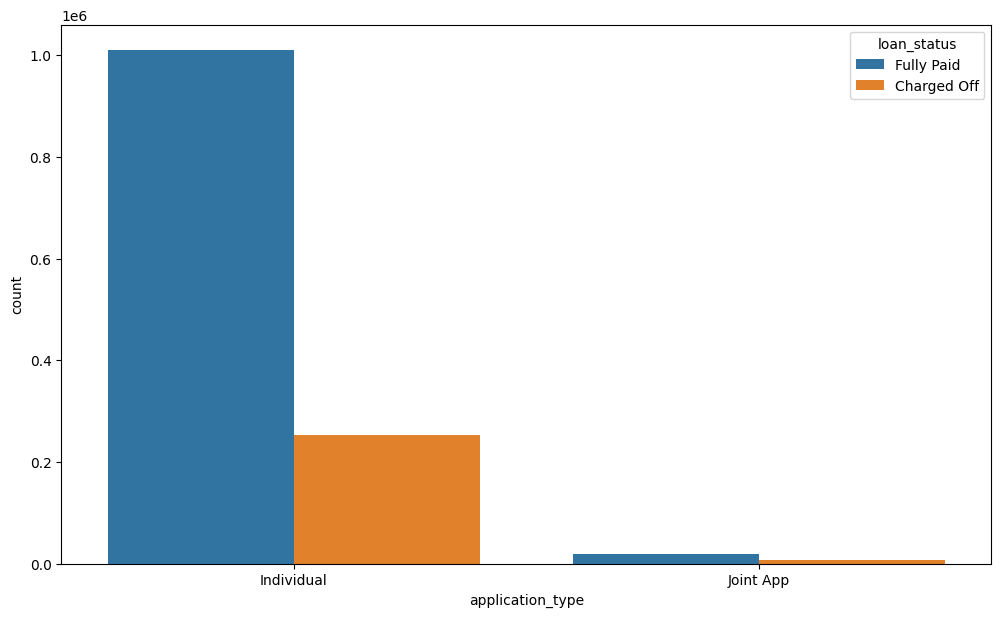

In [97]:
plt.figure(figsize=(12,7))
sns.countplot(x='application_type',data=df,hue='loan_status')

 tỷ lệ phần trăm bị "charged off" theo từng loại application_type

<Axes: xlabel='application_type', ylabel='loan_status'>

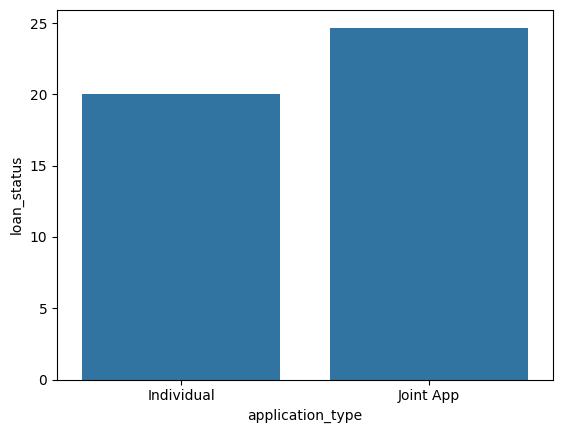

In [98]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("application_type").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("application_type").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
sns.barplot(percentage_charged_off)

Có khác biệt rõ ràng giữa các loại hình cho vay nhà khác nhau

In [99]:
dummies_application_type = pd.get_dummies(df['application_type'], drop_first=False)
df = pd.concat([df.drop('application_type', axis=1), dummies_application_type], axis=1)

In [100]:
df.shape

(1288456, 62)

### 10, initial_list_status


Trạng thái niêm yết ban đầu của khoản vay. Các giá trị có thể là:
<br>
W: Đang chờ xử lý (Waiting).
<br>
F: Đã hoàn tất (Fully funded).

In [101]:
if_null_values('initial_list_status')

No missing values


In [102]:
df['initial_list_status'].value_counts()

initial_list_status
w    747944
f    540512
Name: count, dtype: int64

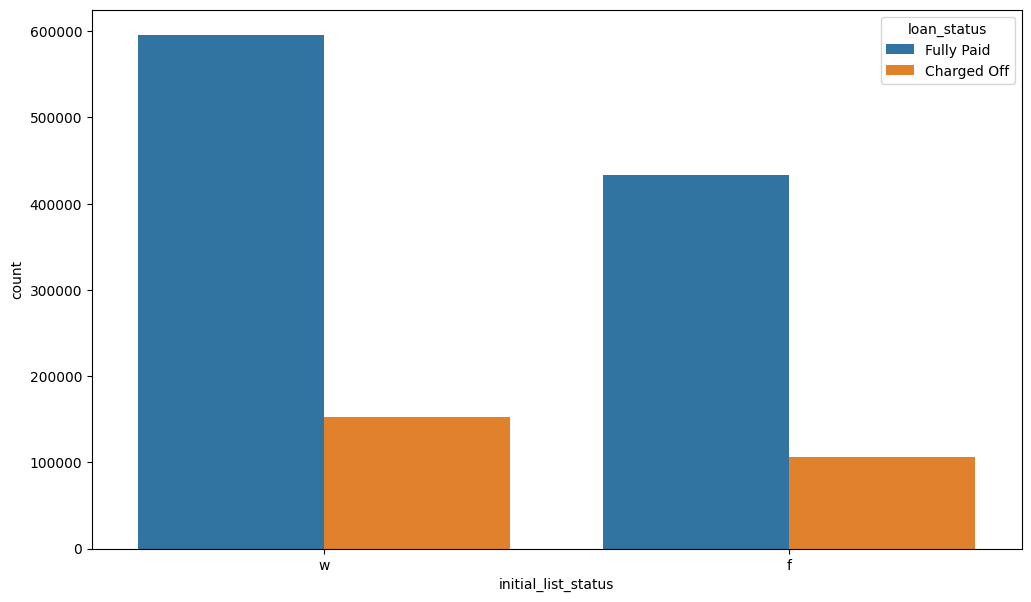

In [103]:
plt.figure(figsize=(12,7))
sns.countplot(x='initial_list_status',data=df,hue='loan_status');

<Axes: xlabel='initial_list_status', ylabel='loan_status'>

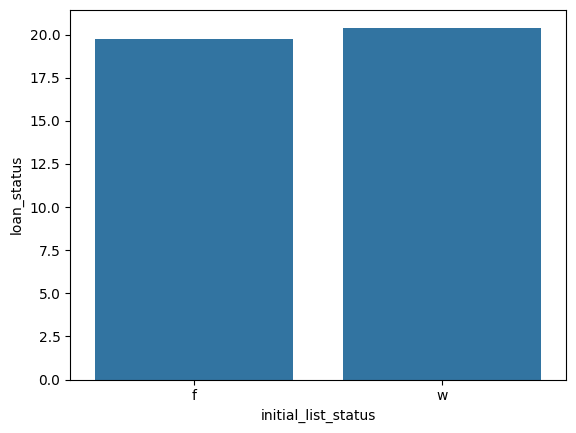

In [104]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("initial_list_status").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("initial_list_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
sns.barplot(percentage_charged_off)

Nhận thấy ngay % Charge off gần như là tương đồng nên giá trị cột này mang lại là không có. Tốt nhất nên loại bỏ.

In [105]:
df = df.drop('initial_list_status', axis=1)

### 11, int_rate


Lãi suất cho khoản vay.

In [106]:
if_null_values('int_rate')

No missing values


In [107]:
df['int_rate'].describe()

count    1.288456e+06
mean     1.327527e+01
std      4.760833e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.279000e+01
75%      1.601000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

In [108]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,259365.0,15.732673,4.904591,5.31,12.29,15.05,18.55,30.99
Fully Paid,1029091.0,12.655918,4.517718,5.31,9.17,12.29,15.31,30.99


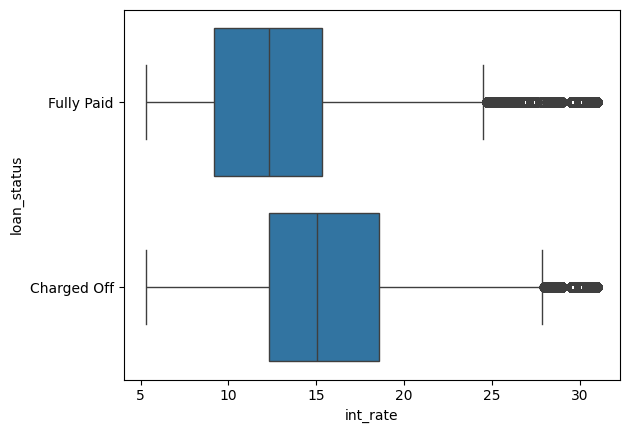

In [109]:
sns.boxplot(data=df, y='loan_status', x='int_rate');

Có sự phân hoá rõ ràng giữa charged off và fully paid theo lãi suất cho vay

### 12, loan_amnt


Số tiền vay được niêm yết. Nếu vào một thời điểm nào đó, bộ phận tín dụng giảm số tiền vay, thì điều này sẽ được phản ánh trong giá trị này.

In [110]:
if_null_values('loan_amnt')

No missing values


In [111]:
df['loan_amnt'].describe()

count    1.288456e+06
mean     1.409236e+04
std      8.480909e+03
min      5.000000e+02
25%      7.600000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

In [112]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,259365.0,15320.169163,8646.880774,900.0,8875.0,14000.0,20000.0,40000.0
Fully Paid,1029091.0,13782.911958,8410.334317,500.0,7200.0,12000.0,19200.0,40000.0


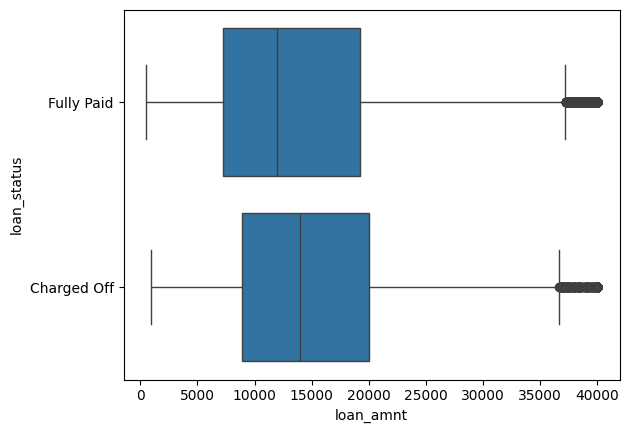

In [113]:
sns.boxplot(data=df, y='loan_status', x='loan_amnt');

Có sự phân hoá rõ ràng giữa charged off và fully paid theo số tiền vay.

### 13, num_bc_tl


Số tài khoản thẻ ngân hàng.

In [114]:
if_null_values('num_bc_tl')

% of missing values = 5.02


In [115]:
df['num_bc_tl'].describe()

count    1.222512e+06
mean     8.036465e+00
std      4.765313e+00
min      0.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.000000e+01
max      7.000000e+01
Name: num_bc_tl, dtype: float64

Ta thấy trung vị là 7 còn trung bình lầ 8 nên trong bài này sẽ thay 7 vào các giá trị thiếu

In [116]:
df['num_bc_tl'] = df['num_bc_tl'].fillna(7)

In [117]:
df['num_bc_tl'].isnull().sum()

np.int64(0)

In [118]:
df.groupby('loan_status')['num_bc_tl'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,259365.0,7.853616,4.658935,0.0,5.0,7.0,10.0,57.0
Fully Paid,1029091.0,8.016133,4.643895,0.0,5.0,7.0,10.0,70.0


In [119]:
q1 = df['num_bc_tl'].quantile(0.25)  
q3 = df['num_bc_tl'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

<Axes: xlabel='num_bc_tl', ylabel='loan_status'>

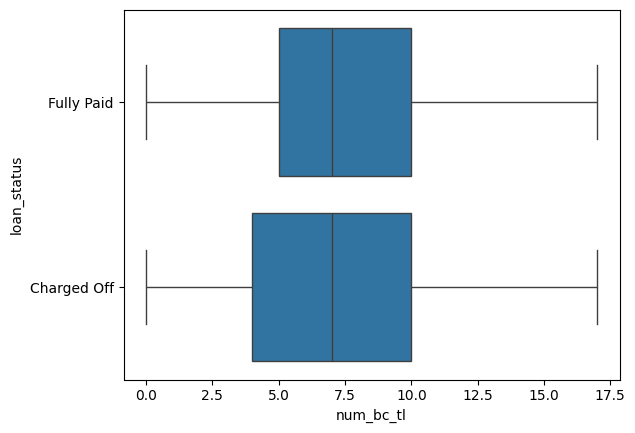

In [120]:
df = df[(df['num_bc_tl'] >= lower_bound) & (df['num_bc_tl'] <= upper_bound)]

sns.boxplot(data=df, y='loan_status', x='num_bc_tl')

không có bất kì sự khác biết giữa 2 giá trị loan status, tốt nhất nên loại bỏ

In [121]:
df = df.drop('num_bc_tl', axis=1)

### 14, mort_acc

Số lượng tài khoản thế chấp

In [122]:
if_null_values('mort_acc')

% of missing values = 3.51


In [123]:
df['mort_acc'].describe()

count    1.188303e+06
mean     1.587714e+00
std      1.930971e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

In [124]:
df['mort_acc'] = df['mort_acc'].fillna(df.groupby('open_acc')['mort_acc'].transform(lambda x:x.value_counts().index[0]))

In [125]:
df['mort_acc'].isnull().sum()

np.int64(0)

In [126]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,248797.0,1.277061,1.759398,0.0,0.0,1.0,2.0,27.0
Fully Paid,985632.0,1.591827,1.951302,0.0,0.0,1.0,3.0,51.0


In [127]:
q1 = df['mort_acc'].quantile(0.25)  
q3 = df['mort_acc'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound

np.float64(7.5)

In [128]:
df = df[(df['mort_acc'] >= lower_bound) & (df['mort_acc'] <= upper_bound)]

In [129]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,246919.0,1.217675,1.621293,0.0,0.0,0.0,2.0,7.0
Fully Paid,973846.0,1.499809,1.760099,0.0,0.0,1.0,3.0,7.0


<Axes: xlabel='mort_acc', ylabel='loan_status'>

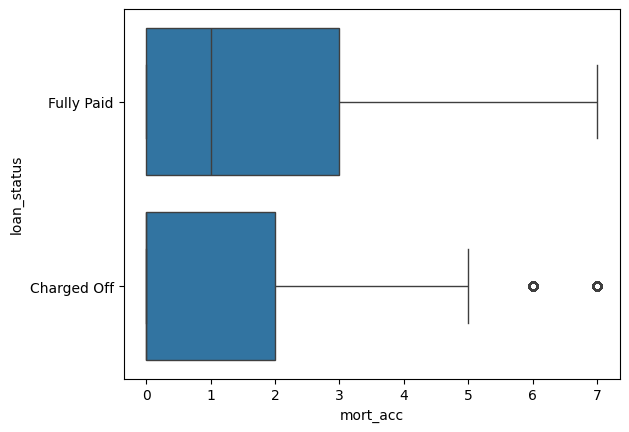

In [130]:
sns.boxplot(data=df, y='loan_status', x='mort_acc')

có sự khác biết rõ dàng giữa 2 thành phần của loan_status khi dựa theo số lượng tải sản thế chấp

### 15, funded_amnt_inv

số tiền mà các nhà đầu tư đã thực sự cam kết hoặc đầu tư vào khoản vay.

In [131]:
if_null_values('funded_amnt_inv')

No missing values


In [132]:
df['funded_amnt_inv'].describe()

count    1.220765e+06
mean     1.387866e+04
std      8.400122e+03
min      0.000000e+00
25%      7.500000e+03
50%      1.200000e+04
75%      1.947500e+04
max      4.000000e+04
Name: funded_amnt_inv, dtype: float64

In [133]:
df.groupby('loan_status')['funded_amnt_inv'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,246919.0,15114.824902,8586.054430,0.0,8500.0,13975.0,20000.0,40000.0
Fully Paid,973846.0,13565.235554,8323.200362,0.0,7100.0,12000.0,18575.0,40000.0


In [134]:
q1 = df['funded_amnt_inv'].quantile(0.25)  
q3 = df['funded_amnt_inv'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound
df = df[(df['funded_amnt_inv'] >= lower_bound) & (df['funded_amnt_inv'] <= upper_bound)]

<Axes: xlabel='funded_amnt_inv', ylabel='loan_status'>

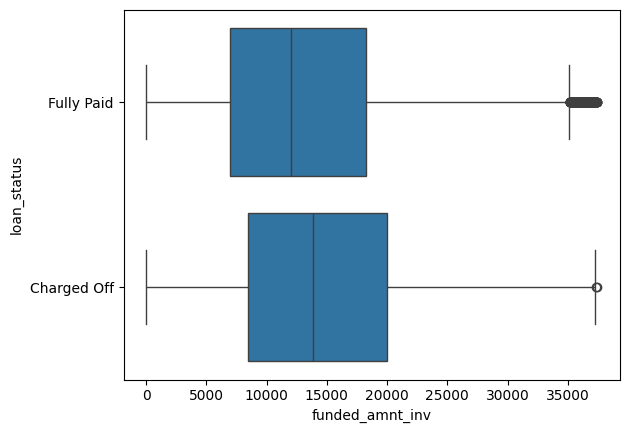

In [135]:
sns.boxplot(data=df, y='loan_status', x='funded_amnt_inv')

Có sự khác biệt nhưng thật sự là không quá nhiều, có thể loại bỏ nếu cần

### 16, dti

tỉ lệ số tiền trả nợ trên tổng thu nhập

In [136]:
if_null_values('dti')

% of missing values = 0.03


In [137]:
df['dti'].sample(10)

673103     25.27
1227918    24.32
1233371     6.70
1618886    17.07
1083365    11.85
278351     29.15
54732      16.34
1821380     8.97
1249981    20.73
1251875    24.02
Name: dti, dtype: float64

In [138]:
df['dti'].describe()

count    1.215355e+06
mean     1.846673e+01
std      1.122663e+01
min     -1.000000e+00
25%      1.202500e+01
50%      1.783000e+01
75%      2.422000e+01
max      9.990000e+02
Name: dti, dtype: float64

Ta lấy giá trị trung vị thay các giá tị bị trống

In [139]:
df['dti'] = df['dti'].fillna(17.86)

In [140]:
q1 = df['dti'].quantile(0.25)  
q3 = df['dti'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound
df = df[(df['dti'] >= lower_bound) & (df['dti'] <= upper_bound)]

<Axes: xlabel='dti', ylabel='loan_status'>

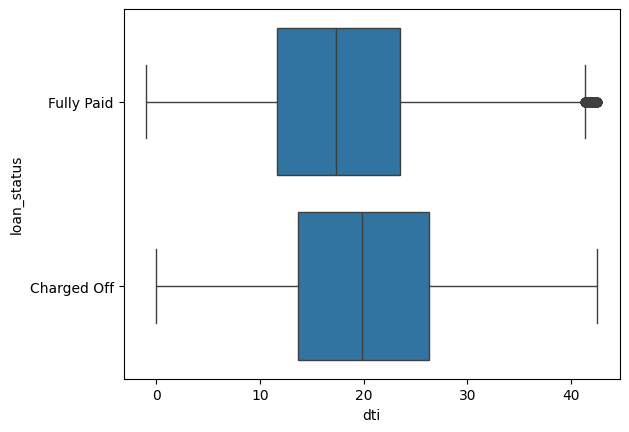

In [141]:
sns.boxplot(data=df, y='loan_status', x='dti')

Có sự phân hoá rõ ràng

### 17, open_acc


Số lượng các hạn mức tín dụng mở trong hồ sơ tín dụng của người vay.

In [142]:
if_null_values('open_acc')

No missing values


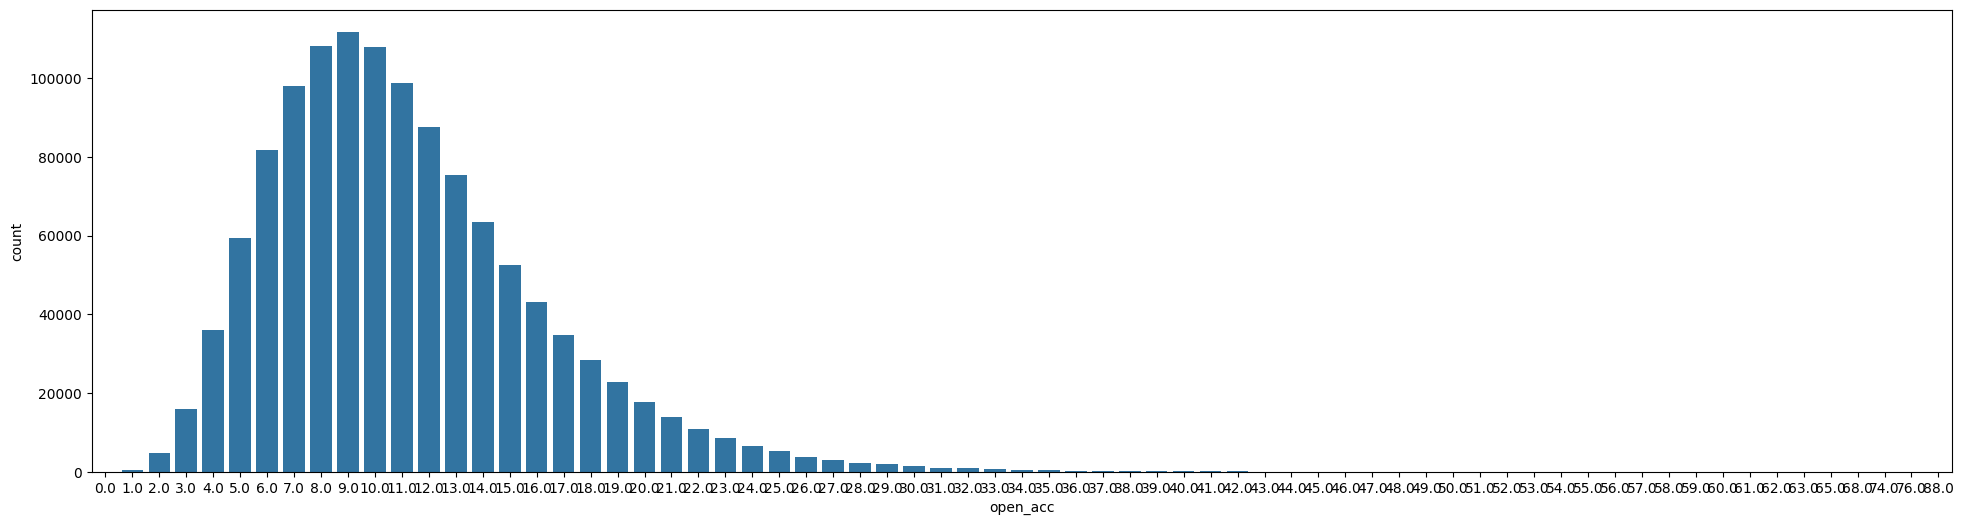

In [143]:
plt.figure(figsize=(24,6))
sns.countplot(data=df, x='open_acc');

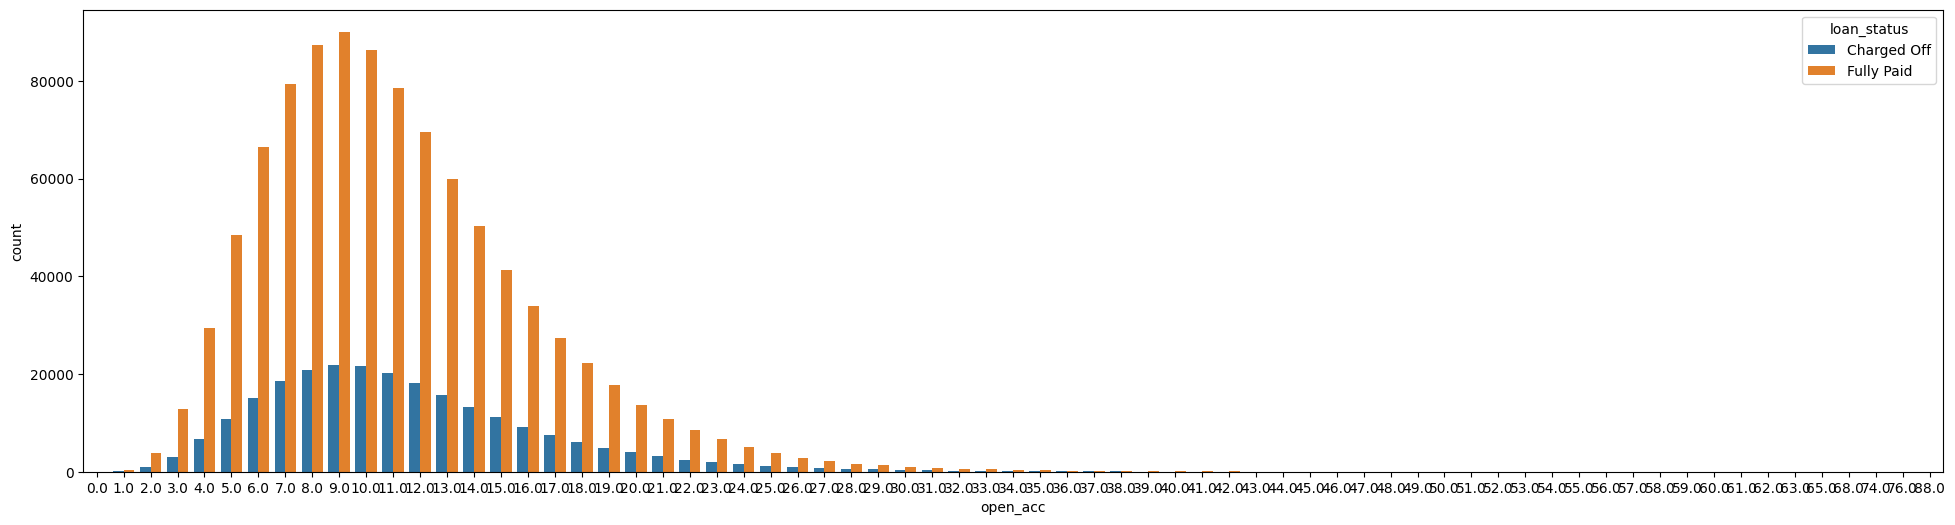

In [144]:
plt.figure(figsize=(24,6))
sns.countplot(data=df, x='open_acc', hue='loan_status');

In [145]:
df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,244247.0,11.502217,5.264329,0.0,8.0,11.0,14.0,76.0
Fully Paid,966474.0,11.084796,5.024821,0.0,8.0,10.0,14.0,88.0


In [146]:
q1 = df['open_acc'].quantile(0.25)  
q3 = df['open_acc'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound
df = df[(df['open_acc'] >= lower_bound) & (df['open_acc'] <= upper_bound)]

<Axes: xlabel='open_acc', ylabel='loan_status'>

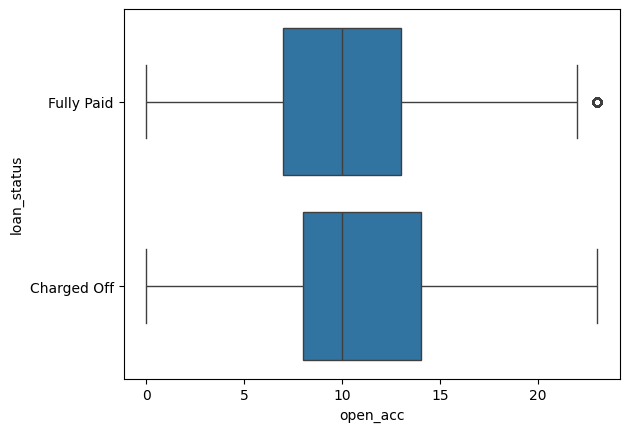

In [147]:
sns.boxplot(data=df, y='loan_status', x='open_acc')

Có sự phân hoá rõ ràng

### 18, inq_last_12m

 số lần người vay đã yêu cầu kiểm tra tín dụng trong vòng 12 tháng qua

In [148]:
if_null_values('inq_last_12m')

% of missing values = 60.04


Quá nhiều giá trị bị thiếu, tốt nhất nên loại bỏ

In [149]:
df = df.drop('inq_last_12m', axis=1)

### 14, installment

khoản tiền phải trả mỗi tháng nếu người vay muốn vay

In [150]:
if_null_values('installment')

No missing values


In [151]:
df.installment.describe()

count    1.181765e+06
mean     4.181148e+02
std      2.461338e+02
min      4.930000e+00
25%      2.404100e+02
50%      3.613800e+02
75%      5.494200e+02
max      1.543090e+03
Name: installment, dtype: float64

In [152]:
df.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,237031.0,447.644180,250.079679,21.62,269.52,389.98,579.76,1543.09
Fully Paid,944734.0,410.705906,244.575174,4.93,232.47,352.25,540.56,1526.38


In [153]:
q1 = df['installment'].quantile(0.25)  
q3 = df['installment'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound
df = df[(df['installment'] >= lower_bound) & (df['installment'] <= upper_bound)]

<Axes: xlabel='installment', ylabel='loan_status'>

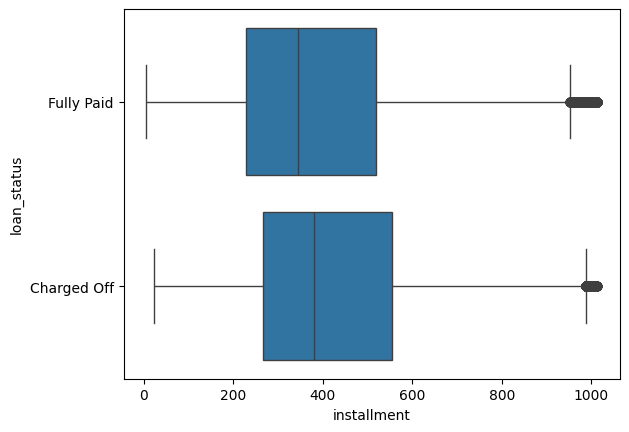

In [154]:
sns.boxplot(data=df, y='loan_status', x='installment')

Có sự phân hoá rõ ràng

### 19, pub_rec_bankruptcies

Số lượng hồ sơ phá sản công khai.

In [155]:
if_null_values('pub_rec_bankruptcies')

% of missing values = 0.05


In [156]:
df['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    1003920
1.0     136750
2.0       5989
Name: count, dtype: int64

In [157]:
df['pub_rec_bankruptcies'].describe()

count    1.146659e+06
mean     1.297055e-01
std      3.511810e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+00
Name: pub_rec_bankruptcies, dtype: float64

Thay thế các giá trị null bằng trung vị

In [158]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [159]:
df['pub_rec_bankruptcies'].isna().sum()

np.int64(0)

In [160]:
df.groupby('loan_status')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,228709.0,0.146160,0.371263,0.0,0.0,0.0,0.0,2.0
Fully Paid,918610.0,0.125516,0.345767,0.0,0.0,0.0,0.0,2.0


<Axes: xlabel='pub_rec_bankruptcies', ylabel='loan_status'>

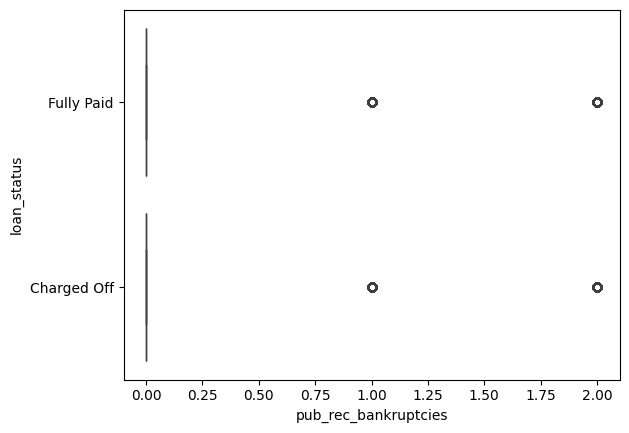

In [161]:
sns.boxplot(data=df, y='loan_status', x='pub_rec_bankruptcies')

### 20, purpose


Một danh mục do người vay cung cấp cho yêu cầu vay.

Danh mục này thường mô tả mục đích vay của người vay, ví dụ như vay để mua nhà, mua ô tô, thanh toán nợ, hoặc vay cho các mục đích cá nhân khác

In [162]:
if_null_values('purpose')

No missing values


In [163]:
len(df['purpose'].unique())

14

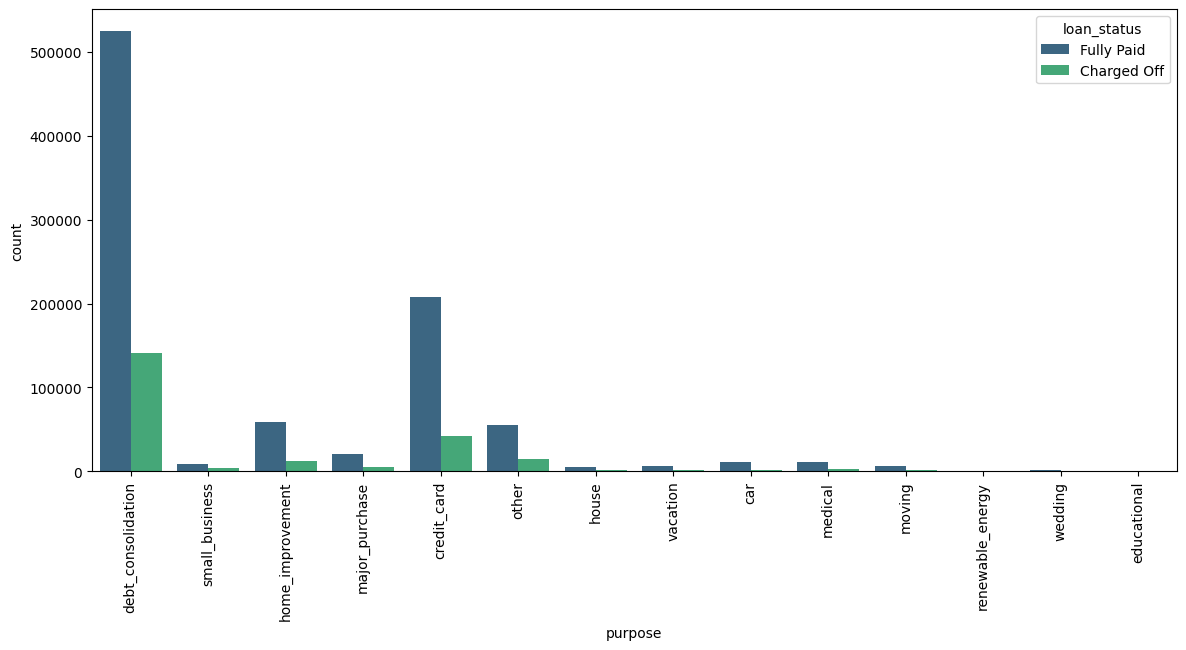

In [164]:
plt.figure(figsize=(14,6))
sns.countplot(data=df,x='purpose', hue='loan_status', palette='viridis');
plt.xticks(rotation=90);

<Axes: xlabel='purpose', ylabel='loan_status'>

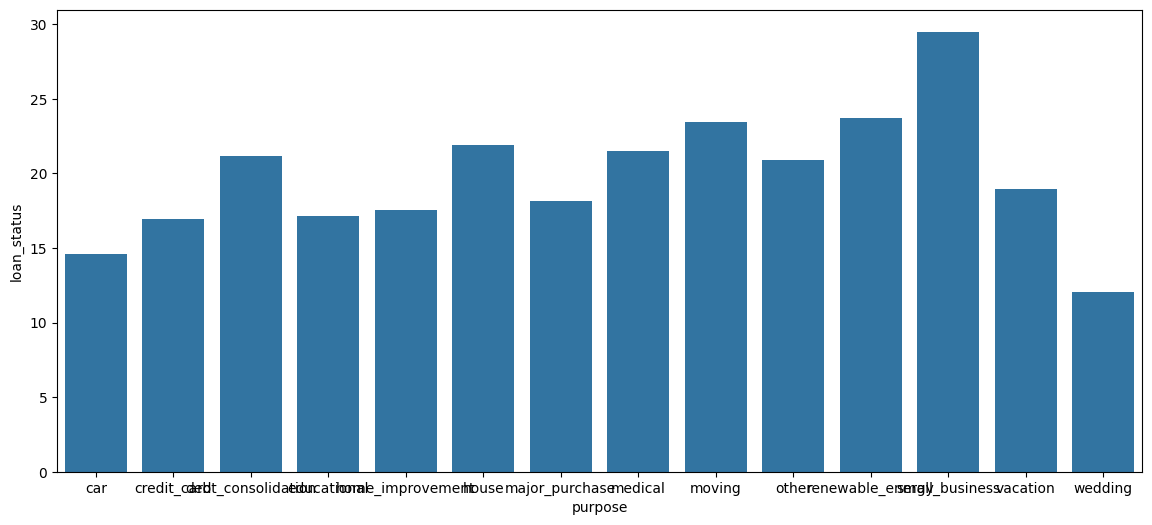

In [165]:
plt.figure(figsize=(14,6))
charged_off = df[df['loan_status']=="Charged Off"].groupby("purpose").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("purpose").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
sns.barplot(percentage_charged_off)

In [166]:
purpose = pd.get_dummies(df['purpose'], drop_first=False)

In [167]:
df = pd.concat([df.drop('purpose', axis=1), purpose], axis=1)

In [168]:
df.shape

(1147319, 72)

### 21, term

Ký hạn khoản thanh toán của khoản vay. Các giá trị được tính theo tháng và có thể là 36 hoặc 60 tháng.

In [169]:
if_null_values('term')

No missing values


In [170]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [171]:
df['term'] = df['term'].apply(lambda x: int(x[0:3]))

<Axes: xlabel='term', ylabel='count'>

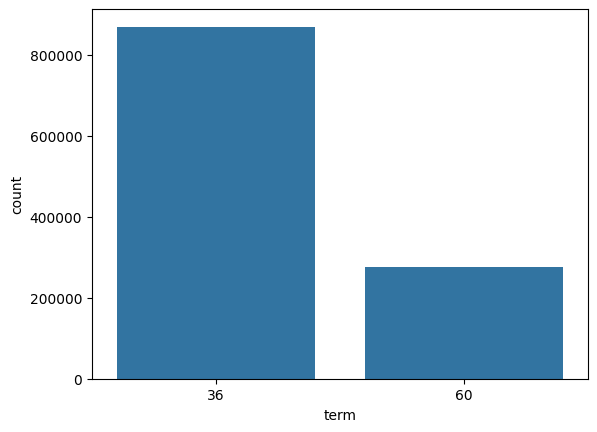

In [172]:
sns.countplot(data=df, x='term')

<Axes: xlabel='term', ylabel='loan_status'>

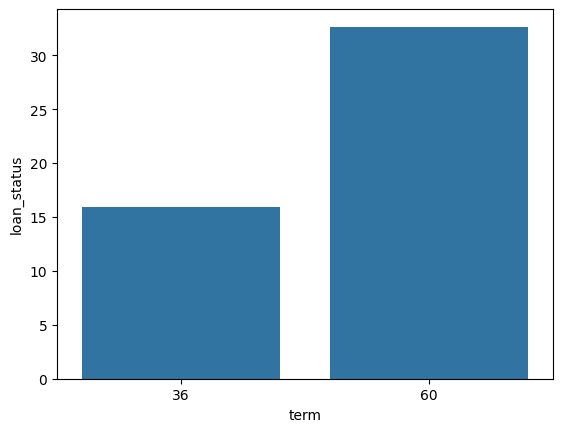

In [173]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("term").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("term").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
sns.barplot(percentage_charged_off)

Những khách hàng có thời hạn vay là 60 tháng có cơ hội được trả nợ gần như gấp đôi.

In [174]:
dummies_term = pd.get_dummies(df['term'], drop_first=False)

In [175]:
df = pd.concat([df.drop('term', axis=1), dummies_term], axis=1)

### 22, title

In [176]:
if_null_values('title')

% of missing values = 1.24


In [177]:
len(df['title'].unique())

56916

In [178]:
df['title'].head(10)

0          Debt consolidation
1                    Business
2                         NaN
4              Major purchase
5          Debt consolidation
7              Major purchase
8     Credit card refinancing
9     Credit card refinancing
12                        NaN
13         Debt consolidation
Name: title, dtype: object

Có quá nhiều giá trị khác biệt nên rất khó trong việc sử lý cũng như sử lý được cũng sẽ có rất nhiều chiều dữ liệu

In [179]:
df = df.drop('title', axis=1)

In [180]:
df.shape

(1147319, 72)

### 23, revol_bal

Tổng số dư tín dụng quay vòng

In [181]:
if_null_values('revol_bal')

No missing values


<Axes: xlabel='revol_bal', ylabel='loan_status'>

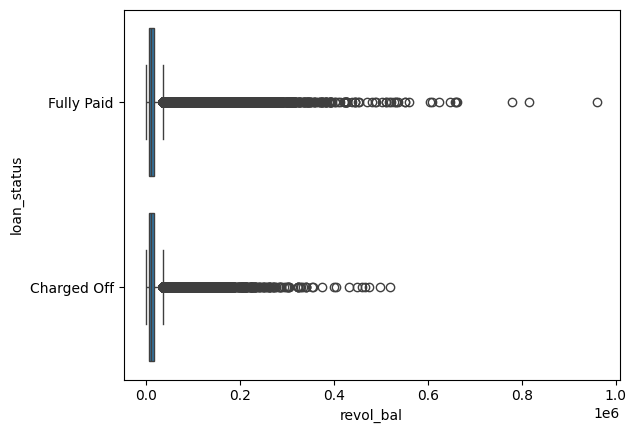

In [182]:
sns.boxplot(data=df, y='loan_status', x='revol_bal')

In [183]:
df['revol_bal'].describe()

count    1.147319e+06
mean     1.405894e+04
std      1.570953e+04
min      0.000000e+00
25%      5.600000e+03
50%      1.030500e+04
75%      1.770300e+04
max      9.597540e+05
Name: revol_bal, dtype: float64

In [184]:
q1 = df['revol_bal'].quantile(0.25)  
q3 = df['revol_bal'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound
df = df[(df['revol_bal'] >= lower_bound) & (df['revol_bal'] <= upper_bound)]

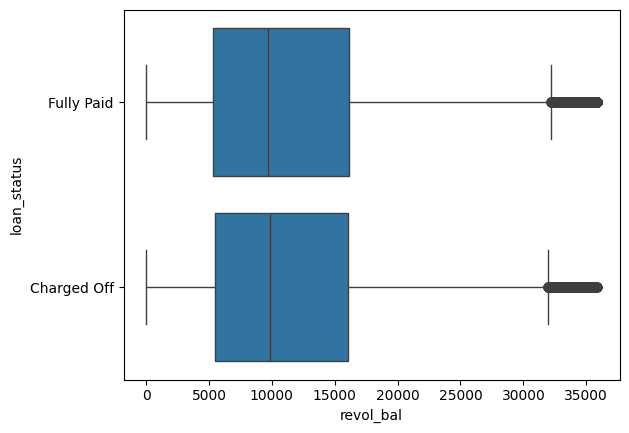

In [185]:
sns.boxplot(data=df, y='loan_status', x='revol_bal');

In [186]:
df.groupby('loan_status')['revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,217933.0,11549.369201,7922.840652,0.0,5462.0,9816.0,16062.0,35851.0
Fully Paid,867622.0,11533.002974,8038.204337,0.0,5347.0,9710.0,16100.0,35856.0


### 24, revol_util

In [187]:
if_null_values('revol_util')

% of missing values = 0.06


In [188]:
df['revol_util'].describe()

count    1.084872e+06
mean     5.127035e+01
std      2.434530e+01
min      0.000000e+00
25%      3.310000e+01
50%      5.150000e+01
75%      6.980000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

Thay thế khuyết thiếu bằng giá trị trung bình

In [189]:
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())

In [190]:
df['revol_util'].isnull().sum()

np.int64(0)

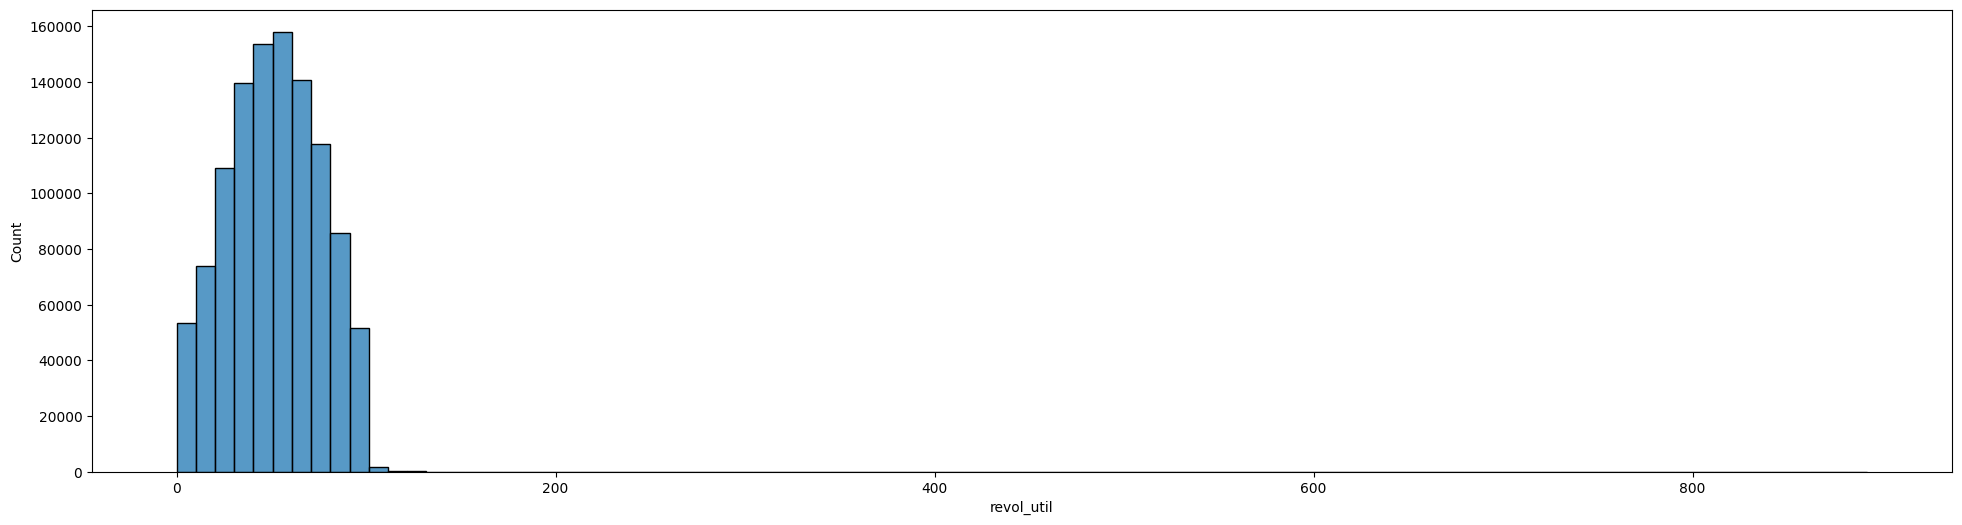

In [191]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='revol_util', bins=88);

In [192]:
q1 = df['revol_util'].quantile(0.25)  
q3 = df['revol_util'].quantile(0.75) 
iqr = q3 - q1 
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
upper_bound
df = df[(df['revol_util'] >= lower_bound) & (df['revol_util'] <= upper_bound)]

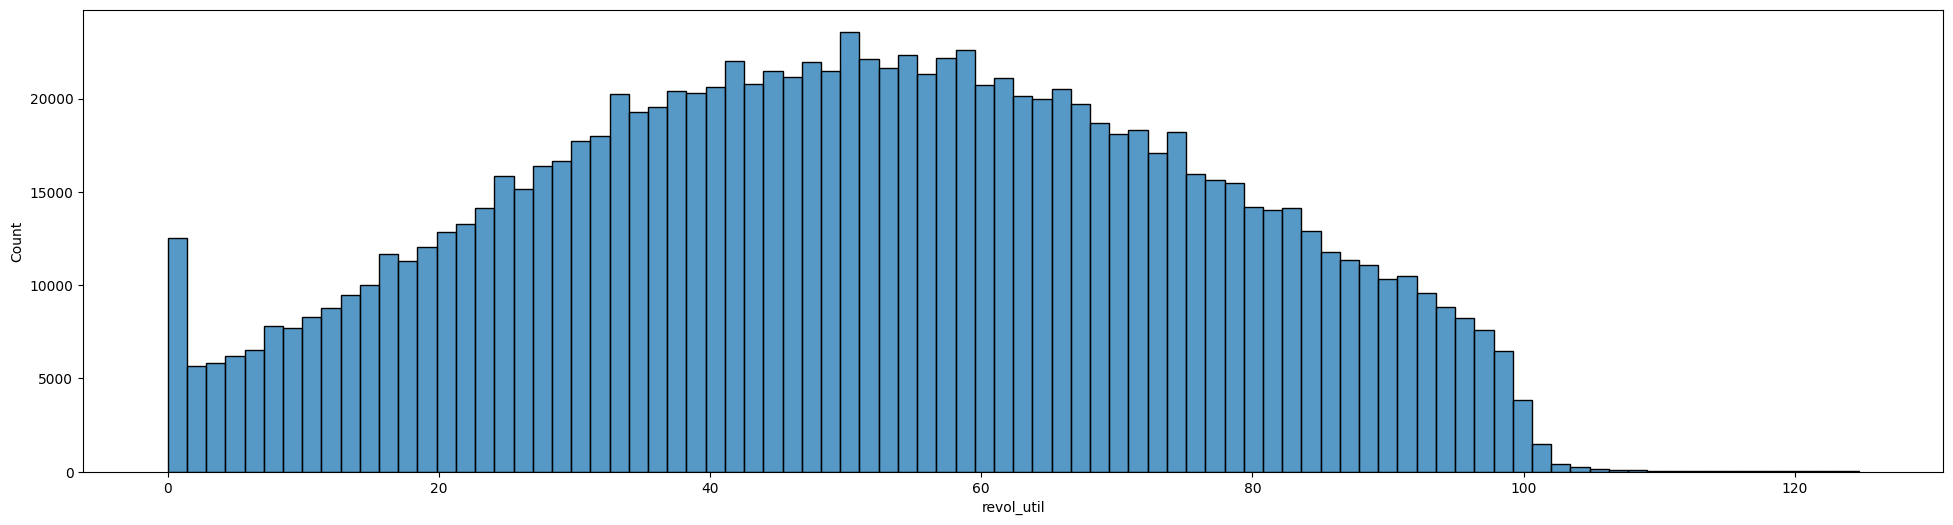

In [193]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='revol_util', bins=88);

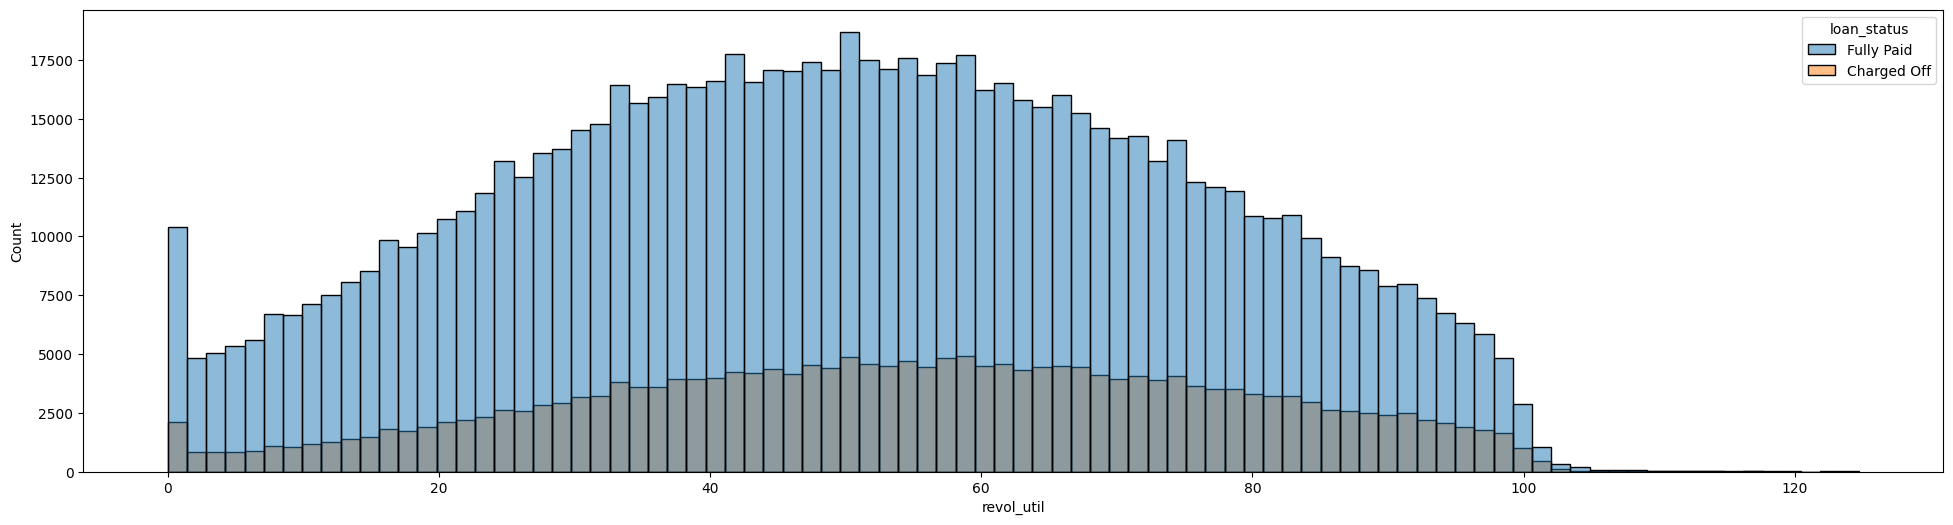

In [194]:
plt.figure(figsize=(24,6))
sns.histplot(data=df, x='revol_util', bins=88, hue='loan_status');

<Axes: xlabel='revol_util', ylabel='loan_status'>

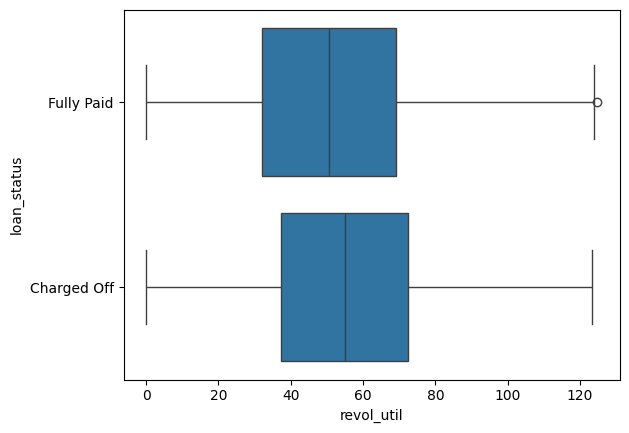

In [195]:
sns.boxplot(data=df, y='loan_status', x='revol_util')

In [196]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,217905.0,54.424703,23.702618,0.0,37.2,55.0,72.5,123.2
Fully Paid,867589.0,50.470815,24.401313,0.0,32.1,50.5,69.1,124.7


Có sự phân hoá rõ ràng

### 25, verification_status

Chỉ ra liệu thu nhập đã được xác minh bởi LC (Lending Club), không được xác minh, hoặc nếu nguồn thu nhập đã được xác minh.

In [197]:
if_null_values('verification_status')

No missing values


In [198]:
df['verification_status'].value_counts()

verification_status
Source Verified    419751
Not Verified       351200
Verified           314543
Name: count, dtype: int64

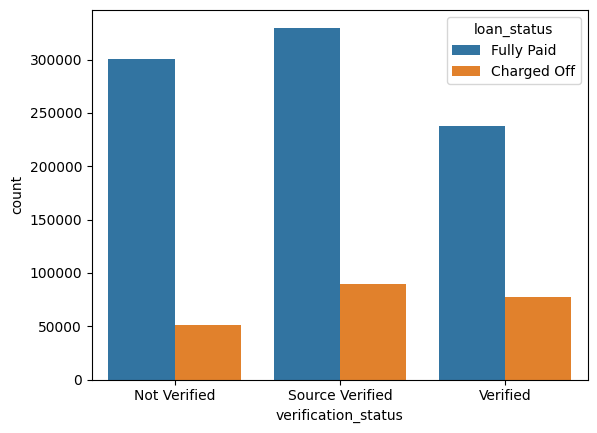

In [199]:
sns.countplot(data=df, x='verification_status', hue='loan_status');

<Axes: xlabel='verification_status', ylabel='loan_status'>

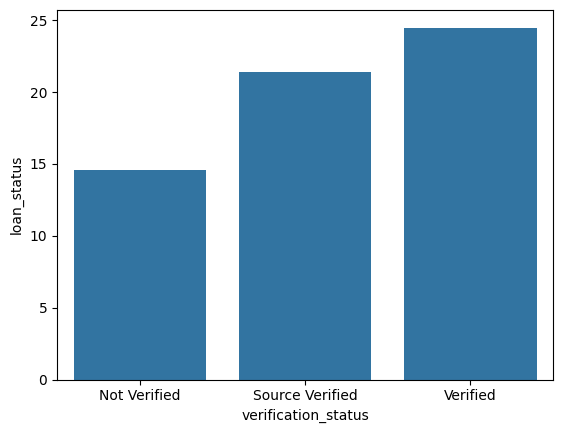

In [200]:
charged_off = df[df['loan_status']=="Charged Off"].groupby("verification_status").count()['loan_status']
fully_paid = df[df['loan_status']=="Fully Paid"].groupby("verification_status").count()['loan_status']
percentage_charged_off = (charged_off * 100)/(charged_off + fully_paid)
sns.barplot(percentage_charged_off)

In [201]:
dummies_verification_status = pd.get_dummies(df['verification_status'], drop_first=False)
df = pd.concat([df.drop('verification_status', axis=1), dummies_verification_status], axis=1)

## III, Modeling

In [202]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [203]:
df['loan_status'].value_counts()

loan_status
1    867589
0    217905
Name: count, dtype: int64

<Axes: xlabel='loan_status', ylabel='count'>

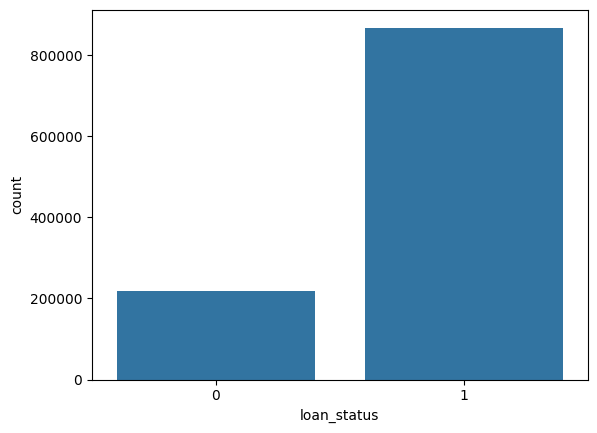

In [204]:
sns.barplot(df['loan_status'].value_counts())

In [205]:
df.dtypes.value_counts()

bool       60
float64    13
int64       1
Name: count, dtype: int64

In [206]:
df.columns = df.columns.astype(str)

In [207]:
df.columns

Index(['annual_inc', 'pub_rec', 'pub_rec_bankruptcies', 'int_rate', 'mort_acc',
       'funded_amnt_inv', 'loan_amnt', 'dti', 'open_acc', 'installment',
       'revol_bal', 'revol_util', 'loan_status', 'fico', 'A1', 'A2', 'A3',
       'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5',
       'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2',
       'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'MORTGAGE', 'OTHER',
       'OWN', 'RENT', 'Individual', 'Joint App', 'car', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', '36', '60', 'Not Verified',
       'Source Verified', 'Verified'],
      dtype='object')

In [208]:
df.isna().sum()

annual_inc              0
pub_rec                 0
pub_rec_bankruptcies    0
int_rate                0
mort_acc                0
                       ..
36                      0
60                      0
Not Verified            0
Source Verified         0
Verified                0
Length: 74, dtype: int64

In [209]:
df.shape 

(1085494, 74)

Giá trị bị lệch khá nhiều về bên 1, có thể sẽ cần undersampling

## IV, Create Models

In [210]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [212]:
X_train.dtypes.value_counts()

bool       60
float64    13
Name: count, dtype: int64

### *** Trước khi sampling

### 1, Ramdom Forest

In [213]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [214]:
preds = rf.predict(X_test)

In [215]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.52      0.09      0.16     65338
           1       0.81      0.98      0.89    260311

    accuracy                           0.80    325649
   macro avg       0.67      0.54      0.52    325649
weighted avg       0.75      0.80      0.74    325649



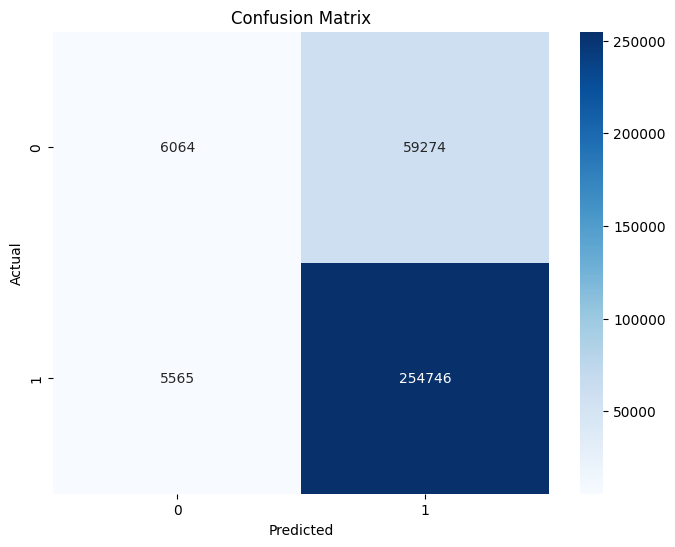

In [216]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 2, Xg boost


In [217]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [218]:
preds = model.predict(X_test) 

In [219]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.55      0.09      0.15     65338
           1       0.81      0.98      0.89    260311

    accuracy                           0.80    325649
   macro avg       0.68      0.54      0.52    325649
weighted avg       0.76      0.80      0.74    325649



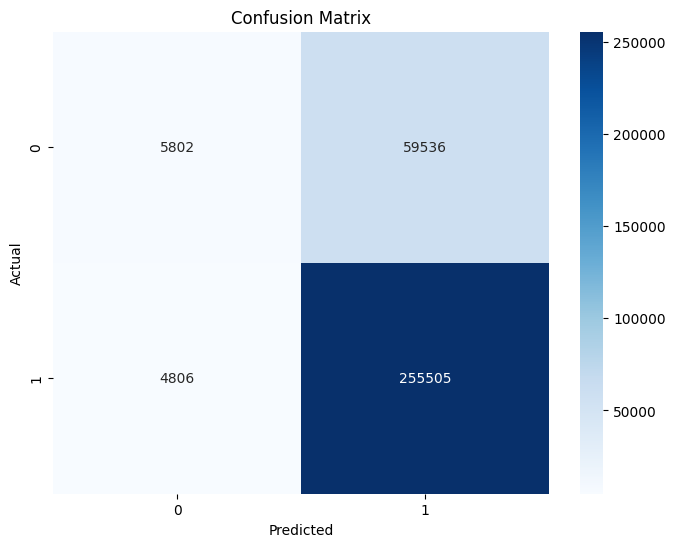

In [220]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

*** Sau khi undersimpling

In [221]:
!pip install imbalanced-learn

In [222]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X_train_resample, y_train_resample=sm.fit_resample(X_train, y_train)

In [237]:
import joblib

### 1, Random Forests

In [224]:
rf_re = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_re.fit(X_train_resample, y_train_resample)

RandomForestClassifier(oob_score=True, random_state=42)

In [238]:
joblib.dump(rf_re, "random_forest_model.joblib", compress=3)

['random_forest_model.joblib']

In [226]:
preds = rf_re.predict(X_test)


In [227]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.48      0.12      0.19     65338
           1       0.81      0.97      0.88    260311

    accuracy                           0.80    325649
   macro avg       0.65      0.54      0.54    325649
weighted avg       0.75      0.80      0.74    325649



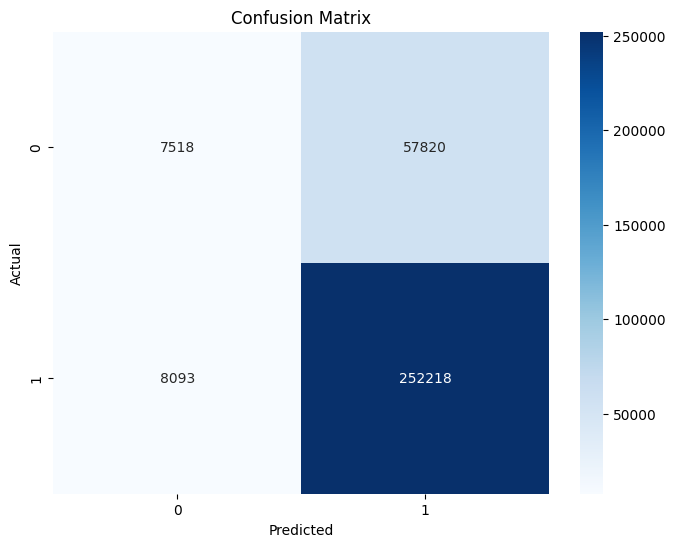

In [228]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 2, Xg boost

In [229]:
model_new = XGBClassifier()
model_new.fit(X_train_resample, y_train_resample)
model_new.save_model('xgb_model.json')

In [230]:
preds = model_new.predict(X_test) 

In [231]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.54      0.09      0.15     65338
           1       0.81      0.98      0.89    260311

    accuracy                           0.80    325649
   macro avg       0.67      0.53      0.52    325649
weighted avg       0.76      0.80      0.74    325649



In [235]:
print(X_test)

         annual_inc  pub_rec  pub_rec_bankruptcies  int_rate  mort_acc  \
1209547     84500.0      0.0                   0.0      8.39       7.0   
16500       26000.0      0.0                   0.0     23.99       0.0   
352781      57000.0      0.0                   0.0     13.99       0.0   
172925      87000.0      1.0                   1.0      8.18       4.0   
1713453     38000.0      1.0                   1.0     11.44       0.0   
...             ...      ...                   ...       ...       ...   
42114       70000.0      0.0                   0.0     13.67       0.0   
1240933     60000.0      0.0                   0.0     13.35       0.0   
185307      57132.0      0.0                   0.0     19.19       0.0   
224822      46500.0      1.0                   1.0     12.69       1.0   
226699     150000.0      0.0                   0.0      9.99       0.0   

         funded_amnt_inv  loan_amnt    dti  open_acc  installment  ...  other  \
1209547          12850.0    12

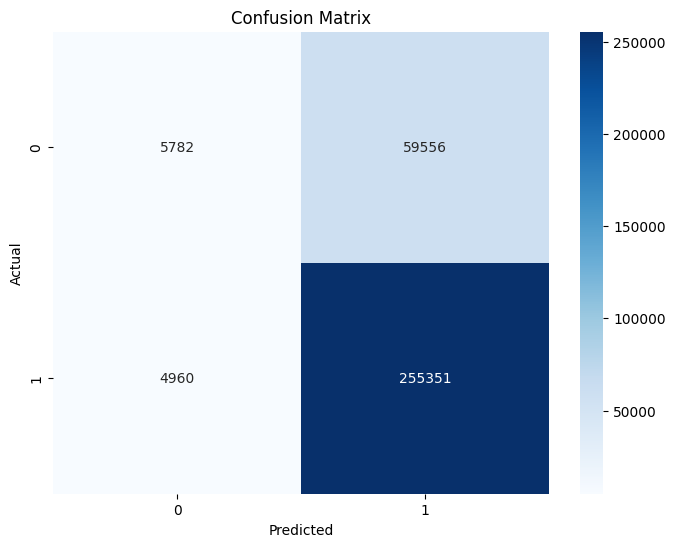

In [232]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()